In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

#source_dirc=svintp.source
#exp_dirc=["aqua_2m/","aqua_20m/","land_rec20m/"]

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# dirc=sys.argv

####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#source='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/land_realtest/'
source_dir='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/'
source = source_dir+'aqua_2m/'
            
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/")
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/")

fig_dest="/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/"

a=6371.0e3
R=a

/home/pragallva/Project1/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

NC=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.nc'))

In [4]:
NC

['/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000058_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000046_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000086_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000034_0010_39.nc']

In [5]:
m5_nc=nc.Dataset(NC[2],'r'); 
m10_nc=nc.Dataset(NC[3],'r'); 
m50_nc=nc.Dataset(NC[1],'r'); 
m100_nc=nc.Dataset(NC[0],'r');
keys=m5_nc.variables.keys()
# print keys

In [6]:
A=nc.Dataset(NC[2],'r').variables['albedo'][:].mean()

In [7]:
print A

0.06999975


In [8]:
longname=[0,0,0]

for i in range(0,len(keys)):
    if ( (i!=2) and (i!=15) and (i!=14) and (i!=16) ) :
#         longname=np.append(longname, m5_nc.variables[keys[i]].long_name)
        print i,'. ',keys[i], '--' ,m5_nc.variables[keys[i]].long_name

0 .  lon -- longitude
1 .  lat -- latitude
3 .  tradl -- thermal radiation 200mb
4 .  sradl -- solar radiation 200mb
5 .  trafl -- thermal radiation 200mb (clear sky)
6 .  srafl -- solar radiation 200mb (clear sky)
7 .  trfliac -- LW flux over ice
8 .  trflwac -- LW flux over water
9 .  trfllac -- LW flux over land
10 .  sofliac -- SW flux over ice
11 .  soflwac -- SW flux over water
12 .  sofllac -- SW flux over land
13 .  friac -- ice cover (fraction of grid box)
17 .  tsw -- surface temperature of water
18 .  ustri -- zonal      wind stress over ice
19 .  vstri -- meridional wind stress over ice
20 .  ustrw -- zonal      wind stress over water
21 .  vstrw -- meridional wind stress over water
22 .  ustrl -- zonal      wind stress over land
23 .  vstrl -- meridional wind stress over land
24 .  ahfliac -- latent heat flux over ice
25 .  ahflwac -- latent heat flux over water
26 .  ahfllac -- latent heat flux over land
27 .  evapiac -- evaporation over ice
28 .  evapwac -- evaporation o

In [ ]:

59 .  srads -- net surface solar radiation
76 .  sradsu -- surface solar radiation upward


In [7]:
# 1 .  lat -- latitude
# 3 .  tradl -- thermal radiation 200mb
# 4 .  sradl -- solar radiation 200mb
# 47 .  ahfs -- sensible heat flux
# 48 .  ahfl -- latent heat flux
# 56 .  tsurf -- surface temperature
# 58 .  albedo -- surface albedo
# 59 .  srads -- net surface solar radiation
# 60 .  trads -- net surface thermal radiation
# 61 .  srad0 -- net top solar radiation
# 62 .  trad0 -- top thermal radiation (OLR)
# 66 .  srad0d -- top incoming solar radiation
# 75 .  srad0u -- top solar radiation upward
# 76 .  sradsu -- surface solar radiation upward
# 77 .  tradsu -- surface thermal radiation upward

In [14]:
def RAD(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    SW_sfc   = R(X['srads'][...]) # net surface solar radiation ---- downwards
    SW_sfc_up= R(X['sradsu'][...]) # net surface solar radiation ---- upwards
    SW_toa   = R(X['srad0'][...]) # net top solar radiation     ---- downwards
    olr      = R(X['trad0'][...])    # top thermal radiation (OLR) --- upwards
    LW_sfc   = R(X['trads'][...]) # net surface thermal radiation  --- upwards
    shflx    = R(X['ahfs'][...])    # ahfs -- sensible heat flux    --- upwards
    lhflx    = R(X['ahfl'][...])    # ahfl -- latent heat flux      --- upwards              
    return SW_sfc, SW_toa, olr, LW_sfc, shflx, lhflx, SW_sfc_up #, SW_toa1   

In [17]:
SW_sfc=np.zeros((4,96,12)); SW_toa=np.copy(SW_sfc); 
LW_sfc=np.copy(SW_sfc); shflx=np.copy(SW_sfc); 
lhflx=np.copy(SW_sfc); olr=np.copy(SW_sfc); SW_toa1=np.copy(SW_sfc); 
SW_sfc_up=np.copy(SW_sfc)

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    SW_sfc[i,...], SW_toa[i,...], olr[i,...], LW_sfc[i,...], shflx[i,...], lhflx[i,...], SW_sfc_up[i,...]  = RAD(X[i])

lat=m5_nc['lat'][:]

In [18]:
SW_sfc_dn = -SW_sfc - SW_sfc_up

In [25]:
d=d+1;
albedo= (SW_sfc_up[d,...].mean()/SW_sfc_dn[d,...].mean()); print albedo

IndexError: index 4 is out of bounds for axis 0 with size 4

In [10]:
# TOA= +SW_toa1 + olr                   ## downwards
# SFC= shflx + lhflx + LW_sfc - SW_sfc   ## upwards
# Net_rad=SFC+TOA

SWABS   = +SW_toa - SW_sfc
SHF     = -(shflx + lhflx + LW_sfc)
Net_rad2= SWABS + SHF + olr

# Check clear sky

In [11]:
def RAD_clsky(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    SW_sfc= R(X['srafs'][...]) # net surface solar radiation ---- downwards
    SW_toa= R(X['sraf0'][...]) # net top solar radiation     ---- downwards
    olr   = R(X['traf0'][...])    # top thermal radiation (OLR) --- upwards
    LW_sfc= R(X['trafs'][...]) # net surface thermal radiation  --- upwards
    shflx = R(X['ahfs'][...])    # ahfs -- sensible heat flux    --- upwards
    lhflx = R(X['ahfl'][...])    # ahfl -- latent heat flux      --- upwards
    return SW_sfc, SW_toa, olr, LW_sfc, shflx, lhflx #, SW_toa1  

In [12]:
SW_sfc_clsky=np.zeros((4,96,12)); SW_toa_clsky=np.copy(SW_sfc_clsky); 
LW_sfc_clsky=np.copy(SW_sfc_clsky); shflx_clsky=np.copy(SW_sfc_clsky); 
lhflx_clsky=np.copy(SW_sfc_clsky); olr_clsky=np.copy(SW_sfc_clsky); SW_toa1_clsky=np.copy(SW_sfc_clsky)

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    SW_sfc_clsky[i,...], SW_toa_clsky[i,...], olr_clsky[i,...], LW_sfc_clsky[i,...], shflx_clsky[i,...], lhflx_clsky[i,...]  = RAD_clsky(X[i])

lat=m5_nc['lat'][:]

In [13]:
SWABS_clsky= +SW_toa_clsky - SW_sfc_clsky
SHF_clsky  = -(shflx_clsky + lhflx_clsky + LW_sfc_clsky)
Net_rad2_clsky= SWABS_clsky + SHF_clsky + olr_clsky

# surface temperature and wind

In [11]:
def temp_and_wind(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    sfc_temp_water= R(X['tsw'][...])   # surface temperature of water
    sfc_temp_land = R(X['tslm1'][...]) # surface temperature of land    
    sfc_temp      = R(X['tsurf'][...])    #  -- surface temperature
    temp_2m= R(X['temp2'][...]) #  -- 2m temperature
    u_10m = R(X['u10'][...])    #  -- 10m u-velocity
    v_10m = R(X['v10'][...])    #  -- 10m v-velocity                   
    return sfc_temp_water, sfc_temp_land, sfc_temp, temp_2m, u_10m, v_10m #, SW_toa1   

In [12]:
sfc_temp_water=np.zeros((4,96,12)); sfc_temp_land=np.copy(sfc_temp_water); 
sfc_temp=np.copy(sfc_temp_water); temp_2m=np.copy(sfc_temp_water); 
u_10m=np.copy(sfc_temp_water); v_10m =np.copy(sfc_temp_water); 

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    sfc_temp_water[i,...], sfc_temp_land[i,...], sfc_temp[i,...], temp_2m[i,...], u_10m[i,...], v_10m[i,...]  = temp_and_wind(X[i])

lat=m5_nc['lat'][:]

In [15]:
def zon_int(x):
    y=x#*2*np.pi*np.cos(np.deg2rad(lat[:,None]))*a
    return y/10**15

import scipy.integrate as integrate
def integrated(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*( int_x_r)#[::-1,:][1:,:] )/1 #
    return avg_int_r/10**15

In [16]:
# d=0
# def D(X,d):
#     return X[d,...].mean(axis=1)-X[d,...].mean()

# # py.figure(1)
# # py.plot(D(SWABS,d),'r-')
# # py.plot(D(SHF,d),'b-')
# # py.plot(D(olr,d),'g-')
# # #py.plot(dhdt[0][:].mean(axis=1),'k-')
# # py.plot(D(Net_rad2,d),'m-')

# # py.plot(D(SWABS_clsky,d),'r--')
# # py.plot(D(SHF_clsky,d),'b--')
# # py.plot(D(olr_clsky,d),'g--')
# # #py.plot(dhdt[0][:].mean(axis=1),'k-')
# # py.plot(D(Net_rad2_clsky,d),'m--')

# # SWABS_clsky= +SW_toa_clsky - SW_sfc_clsky
# # SHF_clsky  = -(shflx_clsky + lhflx_clsky + LW_sfc_clsky)
# # Net_rad2_clsky= SWABS_clsky + SHF_clsky + olr_clsky


# py.figure(2)
# py.plot(D(SW_sfc_clsky,d),'r-')
# py.plot(D(SW_sfc,d),'r--')


In [17]:
MAT=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.mat'))

In [18]:
m5=sio.loadmat(MAT[0]); 
m10=sio.loadmat(MAT[2]); 
m50=sio.loadmat(MAT[1]); 
m100=sio.loadmat(MAT[3]);

In [19]:
def MSE(X):
    MM= (X['mean_cpt_monthly'] +X['mean_gz_monthly'] +X['mean_Lq_monthly']).mean(axis=1)
    SE= (X['seddy_cpt_monthly']+X['seddy_gz_monthly']+X['seddy_Lq_monthly']).mean(axis=1)
    TE= (X['teddy_cpt_monthly']+X['teddy_gz_monthly']+X['teddy_Lq_monthly']).mean(axis=1)
    return zon_int(MM), zon_int(SE), zon_int(TE)    ## Actually it is already 

In [20]:
MM=np.zeros((4,96,12)); SE=np.copy(MM); TE=np.copy(MM)

In [21]:
X=[m5, m10, m50, m100]
for i in range(4) :
    MM[i,...], SE[i,...], TE[i,...] = MSE(X[i])

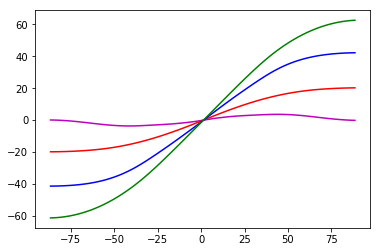

In [22]:
d=2
def D(X):
    return X[...].mean(axis=1)-X[...].mean()

for m in range(1):
    py.plot(lat[:-1], D(integrated(Net_rad2[m,...])), 'm-')
    py.plot(lat[:-1], D(integrated(SWABS[m,...])) ,'r-')
    py.plot(lat[:-1], D(integrated(SHF[m,...])) , 'b-')
    py.plot(lat[:-1], -D(integrated(olr[m,...])), 'g-')
    #py.plot(lat[:], (TE+SE+MM)[m,...].mean(axis=-1))
py.show()

In [23]:
dtheta=np.radians(lat[1]-lat[0])

def spher_div(x):
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for m in range(12):
           div[:,m]= smooth( np.gradient((x[:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat[:])) ),N)
       return div

div_TE=np.copy(TE); div_SE=np.copy(SE); div_MM=np.copy(MM);
 
for d in range(4):
    div_TE[d,...]=spher_div(TE[d,...]*10**15)
    div_SE[d,...]=spher_div(SE[d,...]*10**15)
    div_MM[d,...]=spher_div(MM[d,...]*10**15)
div_NE=div_TE+div_SE+div_MM

In [24]:
from scipy.interpolate import interp1d
def find_zero(div,N=1):
  zero_loc = np.zeros(12)
  for m in range(0,12):
        if N==1 :
         l_range=((lat>=30) & (lat<=60))            
        else    :
         l_range=((lat>=-60) & (lat<=-30))                    
        interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan

        
  return zero_loc

storm_pos_N=np.zeros((4,12)) ; storm_pos_S=np.zeros((4,12));
for d in range(4):
    storm_pos_N[d,:]=find_zero(div_TE[d,...],+1)
    storm_pos_S[d,:]=find_zero(div_TE[d,...],-1)

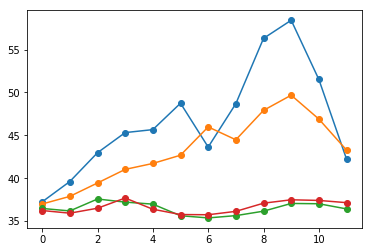

In [25]:
# py.figure(1)
for d in range(4):
    py.plot(storm_pos_N[d,:],'o-')
#   py.plot(-storm_pos_S[d,:],'o--')
py.show()

In [26]:
def plot_flux(n,d) :
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
        
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def add(y):
       y1 = np.append(y,y[:,0,np.newaxis],axis=1)
       return y1    
    
    def a(y):
       y1 = np.append(y,y[0])
       return y1  
    
    v = np.arange(-12.0, 13.0, 2.0)
    latns=lat
    py.subplot(220+n)
    b = py.contourf(range(13),latns,add(TE[d,...]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),latns, add(TE[d,...]), v, colors='k',linewidths=1.0);
    py.plot(range(13), a(storm_pos_N[d,:]), 'ro-')
    py.plot(range(13), a(storm_pos_S[d,:]), 'bo-')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    py.ylim(-80,80)
    #py.plot(range(13),add2(zero_F_TE_N[:-1]),'ro-',lw=5.8,ms=10)
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-80,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)

    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

/home/pragallva/Project1/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


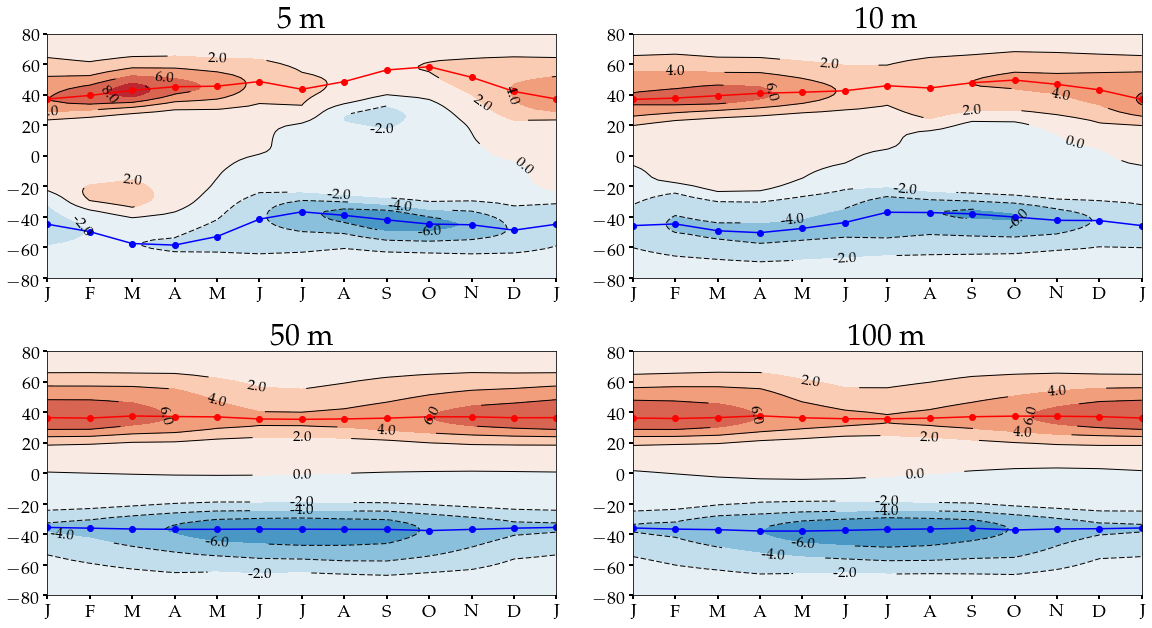

In [27]:
fig=py.figure(figsize=(20, 10))
d=0
plot_flux(d+1,d)
d=1
plot_flux(d+1,d)
d=2
plot_flux(d+1,d)
d=3
plot_flux(d+1,d)

In [28]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,d,N=1):
  D = np.zeros(12)
  for m in range(0,12):
        if N==1 :
          l_range=((lat>=30) & (lat<=60)) 
          X=storm_pos_N
        else    :
          l_range=((lat>=-60) & (lat<=-30))  
          X=storm_pos_S
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[m]==np.nan        
  return D

Intensity_teN=np.copy(storm_pos_N)
Intensity_seN=np.copy(storm_pos_N)
Intensity_mmN=np.copy(storm_pos_N)
Intensity_neN=np.copy(storm_pos_N)
for d in range(4):
    Intensity_teN[d,:]=inerp_at_max(TE,d,N=1)
    Intensity_seN[d,:]=inerp_at_max(SE,d,N=1)
    Intensity_mmN[d,:]=inerp_at_max(MM,d,N=1)
    Intensity_neN[d,:]=inerp_at_max(MM+SE+TE,d,N=1)

In [29]:
Intensity_teS=np.copy(storm_pos_S)
Intensity_seS=np.copy(storm_pos_S)
Intensity_mmS=np.copy(storm_pos_S)
Intensity_neS=np.copy(storm_pos_S)
for d in range(4):
    Intensity_teS[d,:]=inerp_at_max(TE,d,N=-1)
    Intensity_seS[d,:]=inerp_at_max(SE,d,N=-1)
    Intensity_mmS[d,:]=inerp_at_max(MM,d,N=-1)
    Intensity_neS[d,:]=inerp_at_max(MM+SE+TE,d,N=-1)

In [30]:
def threshold(N, S, pos_N, pos_S):
   p_N=np.copy(pos_N)
   p_S=np.copy(pos_S)
   for d in range(4): 
    for m in range(12):
        if (N[d,m]<+1) :
            p_N[d,m]=np.nan            
        if (S[d,m]>-1) :
            p_S[d,m]=np.nan            
    return p_N, p_S

pos_N, pos_S = threshold(Intensity_teN, Intensity_teS, storm_pos_N, storm_pos_S)            

In [31]:
def plot_flux(n,d) :
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
        
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def add(y):
       y1 = np.append(y,y[:,0,np.newaxis],axis=1)
       return y1    
    
    def a(y):
       y1 = np.append(y,y[0])
       return y1  
    
    v = np.arange(-12.0, 13.0, 1.0)
    latns=lat
    py.subplot(220+n)
    b = py.contourf(range(13),latns,add(TE[d,...]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),latns, add(TE[d,...]), v, colors='k',linewidths=1.0);
    py.plot(range(13), a(storm_pos_N[d,:]), 'ro-')
    py.plot(range(13), a(storm_pos_S[d,:]), 'bo-')
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    py.ylim(-80,80)
    #py.plot(range(13),add2(zero_F_TE_N[:-1]),'ro-',lw=5.8,ms=10)
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-80,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)
    py.ylim(-90,0)

    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

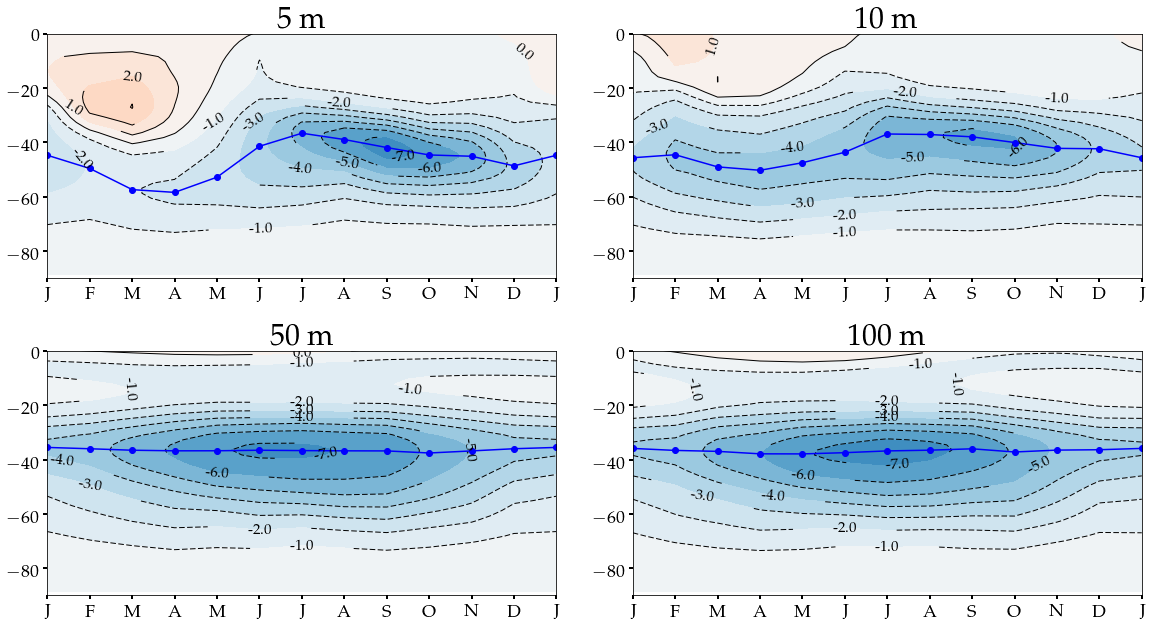

In [32]:
fig=py.figure(figsize=(20, 10))
d=0
plot_flux(d+1,d)
d=1
plot_flux(d+1,d)
d=2
plot_flux(d+1,d)
d=3
plot_flux(d+1,d)

1


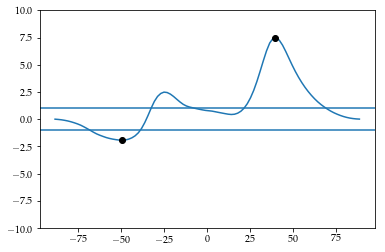

In [41]:
m=m+1
d=0
py.plot(lat, TE[d][:,m])
py.axhline(1)
py.axhline(-1)
py.plot(storm_pos_N[d,m],Intensity_teN[d,m],'ko' )
py.plot(storm_pos_S[d,m],Intensity_teS[d,m],'ko' )
py.ylim(-10,10)
print m

In [42]:
SWABS= +SW_toa - SW_sfc
SHF  = -(shflx + lhflx + LW_sfc)
Net_rad2= SWABS + SHF + olr

#dhdt=Net_rad2-(div_TE+div_SE+div_MM)
#Net_rad2= SWABS + SHF + olr -dhdt


In [43]:
def interp_rad(rad,N=1):
  D = np.zeros((4,12))
  for m in range(0,12):
       for d in range(0,4) :
            latr=lat[1:-1]
            if N==1 :
              l_range=((latr>=30) & (latr<=70)) 
              X=storm_pos_N
            else    :
              l_range=((latr>=-70) & (latr<=-30))  
              X=storm_pos_S
            interpolation_function = interp1d(latr[l_range],rad[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

In [44]:
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1])#int_x[::-1][1:]+/2.0
    return avg_int_r/10**15

In [45]:
Iswabs=np.zeros((4,len(lat[1:-1]),12))
Ishf=np.copy(Iswabs); Ine=np.copy(Iswabs); Iolr=np.copy(Iswabs);Idhdt=np.copy(Iswabs)
def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    Iswabs[d,...]=interad(A(SWABS[d,...]))
    Ishf[d,...]  =interad(A(SHF[d,...]))
#    Ine[d,...]   =interad(Net_rad2[d,...]-Net_rad2[d,:,:].mean(axis=0)[None,:])
    Iolr[d,...]  =interad(A(olr[d,...]))
    #Idhdt[d,...] =interad(A(dhdt[d,...]))
 
Ine=Iswabs+Ishf+Iolr#-Idhdt


In [46]:
Iswabs_clsky=np.zeros((4,len(lat[1:-1]),12))
Ishf_clsky=np.copy(Iswabs_clsky); Ine_clsky=np.copy(Iswabs_clsky); Iolr_clsky=np.copy(Iswabs_clsky);Idhdt_clsky=np.copy(Iswabs_clsky)
def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    Iswabs_clsky[d,...]=interad(A(SWABS_clsky[d,...]))
    Ishf_clsky[d,...]  =interad(A(SHF_clsky[d,...]))
#    Ine[d,...]   =interad(Net_rad2[d,...]-Net_rad2[d,:,:].mean(axis=0)[None,:])
    Iolr_clsky[d,...]  =interad(A(olr_clsky[d,...]))
    #Idhdt[d,...] =interad(A(dhdt[d,...]))
 
Ine_clsky=Iswabs_clsky+Ishf_clsky+Iolr_clsky#-Idhdt


NameError: name 'SWABS_clsky' is not defined

In [47]:
np.cos(np.radians(60))

0.50000000000000011

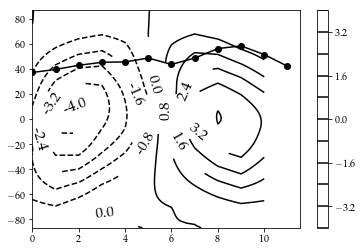

In [48]:
c=py.contour( range(11),lat[1:-1],Iswabs[0,:,1:]-Iswabs[0,:,:-1],10,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
py.plot( range(12),storm_pos_N[0,:],'ko-')
py.colorbar()

In [55]:
I_SWAB_N=interp_rad(Iswabs,N=1)
I_SHF_N =interp_rad(Ishf,N=1)
I_NE_N  =interp_rad(Ine,N=1)
I_OLR_N =interp_rad(Iolr,N=1)
I_dhdt_N =interp_rad(Idhdt,N=1)

In [56]:
Ine[d,:,m].shape

(94,)

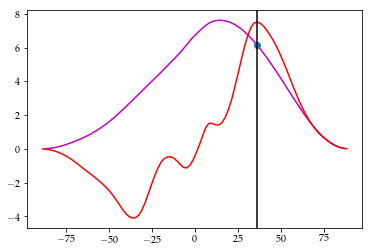

In [57]:
m=0; d=3;
Ine.shape;
py.plot(lat[1:-1],Iswabs[d,:,m],'m')
py.plot(lat[:],TE[d,:,m],'r')
py.plot(storm_pos_N[d,m],I_SWAB_N[d,m], 'o')
py.axvline(storm_pos_N[d,m], color='k')

In [58]:
I_SWAB_S=interp_rad(Iswabs,N=-1)
I_SHF_S =interp_rad(Ishf,N=-1)
I_NE_S  =interp_rad(Ine,N=-1)
I_OLR_S =interp_rad(Iolr,N=-1)
I_dhdt_S =interp_rad(Idhdt,N=-1)

1


(-90, 90)

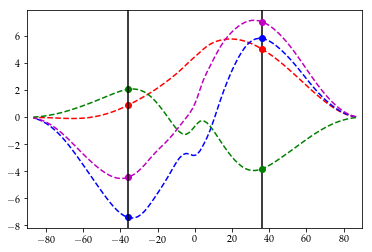

In [59]:
m=m+1; d=2
print m
py.plot(lat[1:-1],Iswabs[d,:,m],'r--')
py.plot(lat[1:-1],Ishf[d,:,m],'b--')
py.plot(lat[1:-1],Iolr[d,:,m],'g--')
py.plot(lat[1:-1],Ine[d,:,m],'m--')
py.axvline(storm_pos_N[d,m],color='k')
py.plot(storm_pos_N[d,m],I_SWAB_N[d,m],'ro')
py.plot(storm_pos_N[d,m],I_SHF_N[d,m],'bo')
py.plot(storm_pos_N[d,m],I_OLR_N[d,m],'go')
py.plot(storm_pos_N[d,m],I_NE_N[d,m],'mo')

py.plot(storm_pos_S[d,m],I_SWAB_S[d,m],'ro')
py.plot(storm_pos_S[d,m],I_SHF_S[d,m],'bo')
py.plot(storm_pos_S[d,m],I_OLR_S[d,m],'go')
py.plot(storm_pos_S[d,m],I_NE_S[d,m],'mo')

py.axvline(storm_pos_S[d,m],color='k')


py.xlim(-90,90)


In [60]:
storm_pos_N[0,m]

39.6210472880149

# Intensity decomposition 

In [61]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_delta_NE(d,N,l):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    fig=py.figure(figsize=(15, 9))        
    if N==1 :    
        py.plot(D(I_NE_N,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(D(I_SWAB_N,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
        py.plot(D(I_SHF_N,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
        py.plot(D(I_OLR_N,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    if N==-1 :
        py.plot(D(I_NE_S,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(D(I_SWAB_S,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
        py.plot(D(I_SHF_S,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
        py.plot(D(I_OLR_S,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
    title="NE decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="NE_decomposition_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=2,frameon=False, loc='best')
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/NE_decomposition_NH_50m.pdf
2


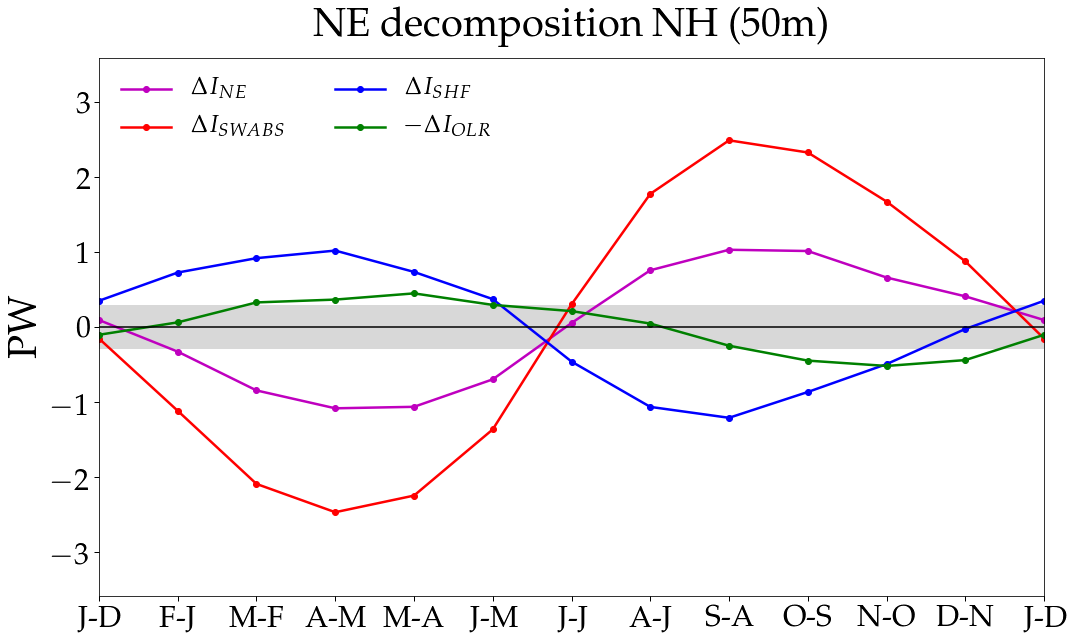

In [54]:
d=2;l=3.6
plot_delta_NE(d,1,l)
print d

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/NE_decomposition_SH_50m.pdf


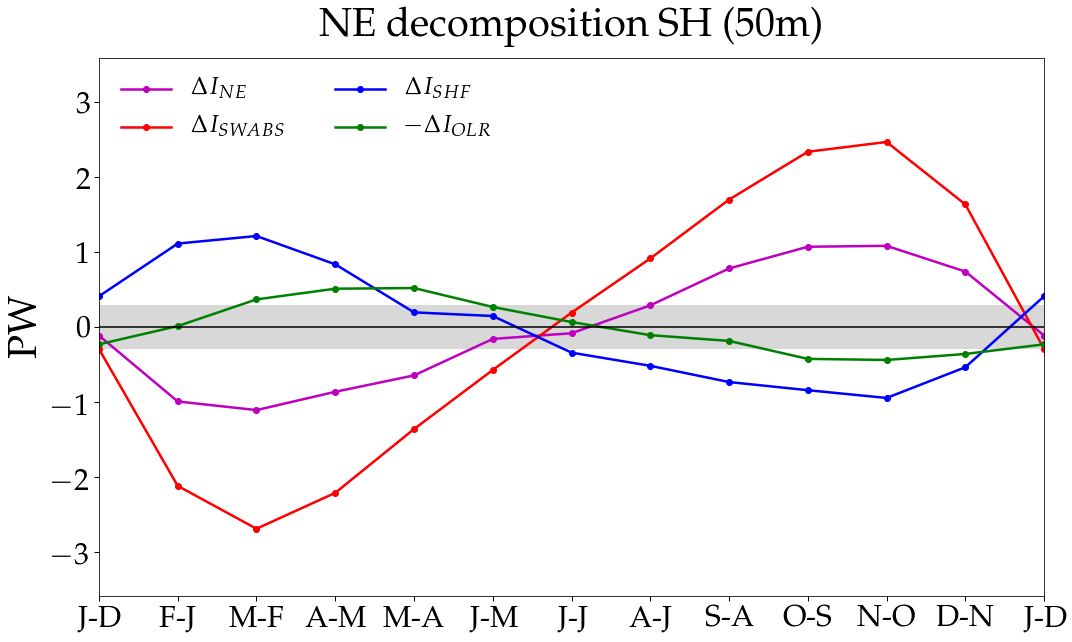

In [55]:
plot_delta_NE(d,-1,l)

3


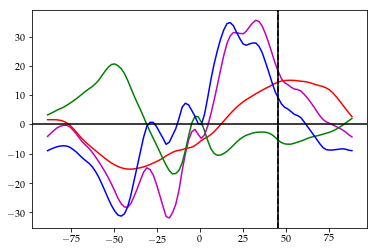

In [56]:
d=0;#m=m+1
m=3
def D(Y):
    X=Y*np.cos(np.deg2rad(lat))[:,None]  # -np.average(Y,axis=0,weights=np.cos(np.deg2rad(lat)))
    X=X-X.mean(axis=0)
    return X[:,1:]-X[:,:-1]

py.plot(lat,D(Net_rad2[d])[:,m],'m-')
py.plot(lat,D(SWABS[d,...])[:,m],'r-')
py.plot(lat,D(olr[d,...])[:,m],'g-')
py.plot(lat,D(SHF[d,...])[:,m],'b-')

py.axvline(storm_pos_N[d,m],color='k')
py.axvline(storm_pos_N[d,m+1],color='k',ls='--')
py.axhline(0,color='k')
print m

3


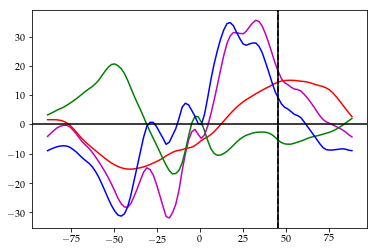

In [57]:
d=0;#m=m+1
m=3
def D(Y):
    X=Y*np.cos(np.deg2rad(lat))[:,None]  # -np.average(Y,axis=0,weights=np.cos(np.deg2rad(lat)))
    X=X-X.mean(axis=0)
    return X[:,1:]-X[:,:-1]

py.plot(lat,D(Net_rad2[d])[:,m],'m-')
py.plot(lat,D(SWABS[d,...])[:,m],'r-')
py.plot(lat,D(olr[d,...])[:,m],'g-')
py.plot(lat,D(SHF[d,...])[:,m],'b-')

py.axvline(storm_pos_N[d,m],color='k')
py.axvline(storm_pos_N[d,m+1],color='k',ls='--')
py.axhline(0,color='k')
print m

In [42]:
SWABS.shape

(4, 96, 12)

In [58]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_intensity(d,N,l):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    fig=py.figure(figsize=(15, 9))        
    if N==1 :    
        py.plot(D(Intensity_teN,d),'ro-',label=r'$\Delta I$',lw=2.5)
        py.plot(D(Intensity_neN,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)   
        py.plot(-D(Intensity_seN,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
        py.plot(-D(Intensity_mmN,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
             
    if N==-1 :
        py.plot(D(Intensity_teS,d),'ro-',label=r'$\Delta I$',lw=2.5)
        py.plot(D(Intensity_neS,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(-D(Intensity_seS,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
        py.plot(-D(Intensity_mmS,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
                                 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-3,3)
    py.ylabel("PW", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
    title="Intensity decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/Intensity_decomposition_SH_5m.pdf


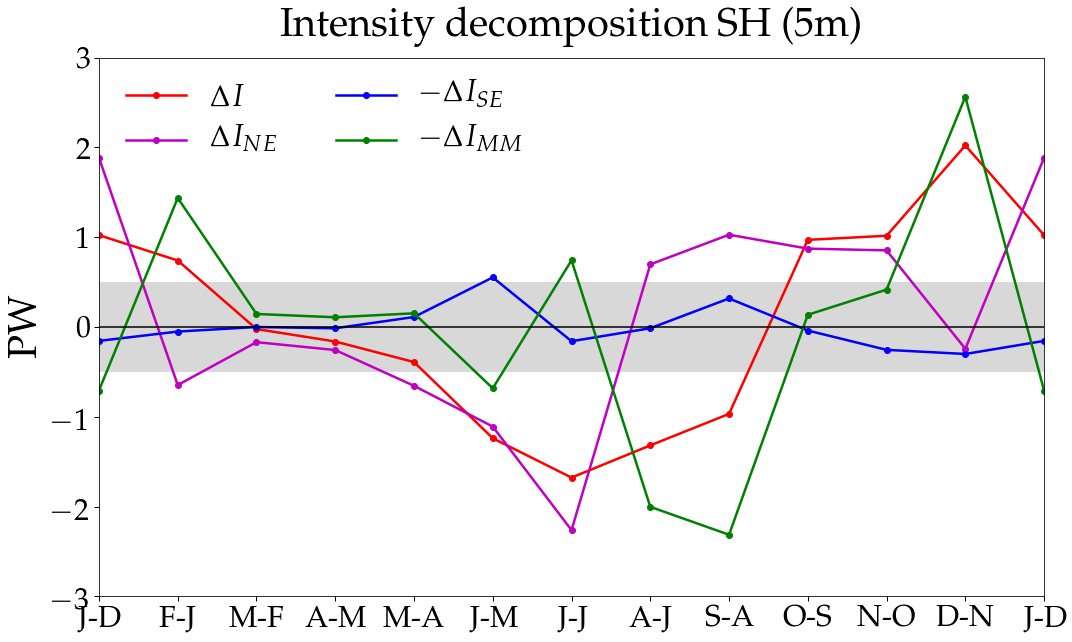

In [59]:
d=0;N=-1;l=3
plot_intensity(d,N,l)

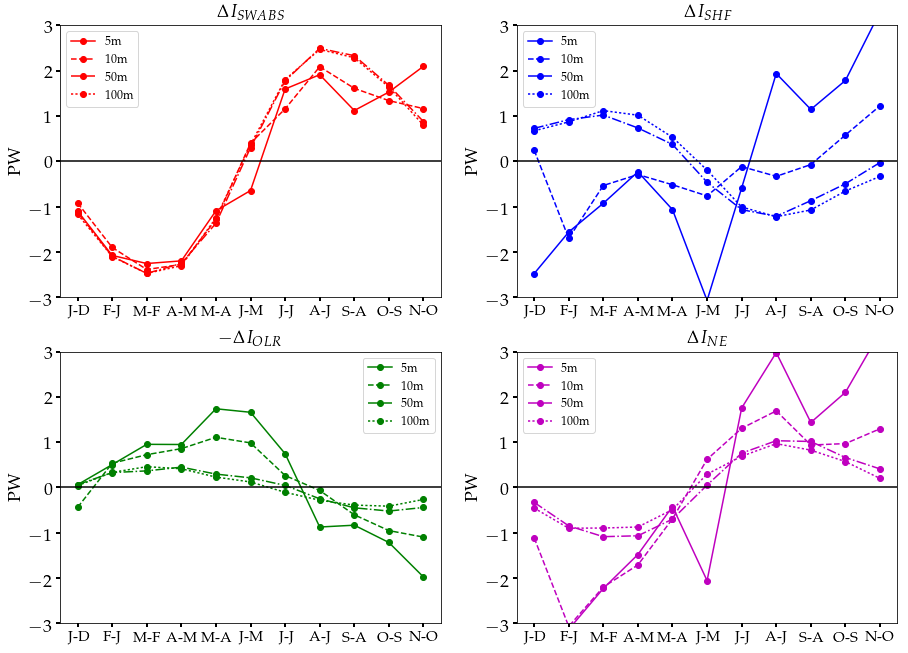

In [133]:
# def compare_plot(n,X,c,T,l=3.5):
#     py.subplot(220+n)
#     d=0
#     def diff(Y):
#         return Y[1:]-Y[:-1]
#     py.plot(diff(X[d,:]),c+'-',label='5m')
#     py.plot(diff(X[d+1,:]),c+'--',label='10m')
#     py.plot(diff(X[d+2,:]),c+'-.',label='50m')
#     py.plot(diff(X[d+3,:]),c+':',label='100m')
#     py.legend(loc='best')
#     py.axhline(0,color='k')
#     py.ylim(-1*l,1*l)
#     py.title(T)
    
# fig=py.figure(figsize=(10, 7))
# compare_plot(1,I_SWAB_N,'r',r'$\Delta I_{SWABS}$')
# compare_plot(2,I_SHF_N,'b',r'$\Delta I_{SHF}$')
# compare_plot(3,I_OLR_N,'g',r'$ - \Delta I_{OLR}$')
# compare_plot(4,I_NE_N,'m',r'$\Delta I_{NE}$')



def compare_plot(n,X,c,T,l=3):
    py.subplot(220+n)
    d=0
    def diff(Y):
        return Y[1:]-Y[:-1]
    py.plot(diff(X[d,:]),c+'o-',label='5m')
    py.plot(diff(X[d+1,:]),c+'o--',label='10m')
    py.plot(diff(X[d+2,:]),c+'o-.',label='50m')
    py.plot(diff(X[d+3,:]),c+'o:',label='100m')
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel('PW',fontsize=18)
    py.legend(loc='best',fontsize=12)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=18)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xticks(range(11), mticks,size=15)

fig=py.figure(figsize=(15, 11))
compare_plot(1,I_SWAB_N,'r',r'$\Delta I_{SWABS}$')
compare_plot(2,I_SHF_N,'b',r'$\Delta I_{SHF}$')
compare_plot(3,I_OLR_N,'g',r'$ - \Delta I_{OLR}$')
compare_plot(4,I_NE_N,'m',r'$\Delta I_{NE}$')


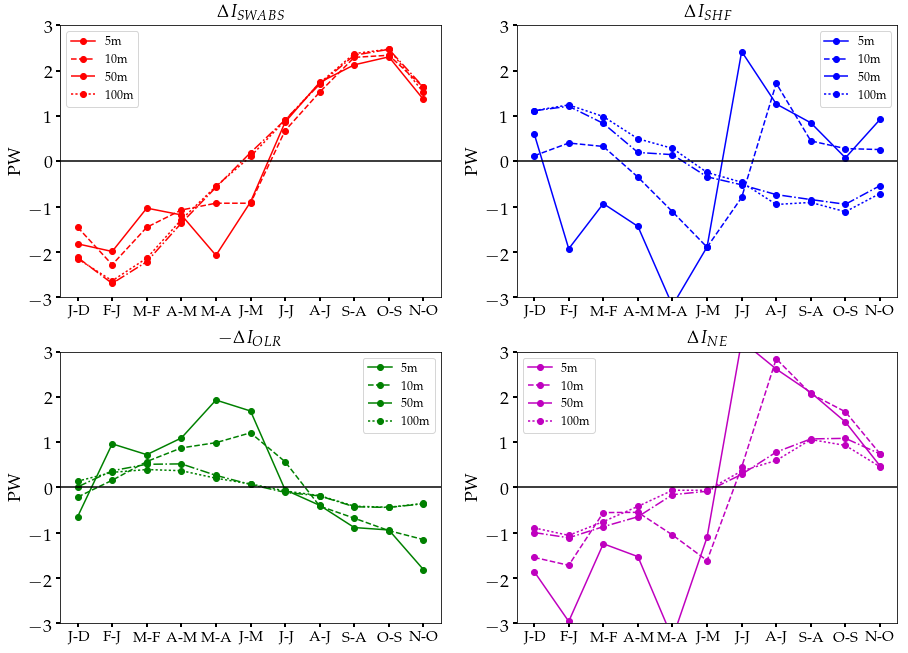

In [134]:
fig=py.figure(figsize=(15, 11))
compare_plot(1,I_SWAB_S,'r',r'$\Delta I_{SWABS}$')
compare_plot(2,I_SHF_S,'b',r'$\Delta I_{SHF}$')
compare_plot(3,I_OLR_S,'g',r'$ - \Delta I_{OLR}$')
compare_plot(4,I_NE_S,'m',r'$\Delta I_{NE}$')

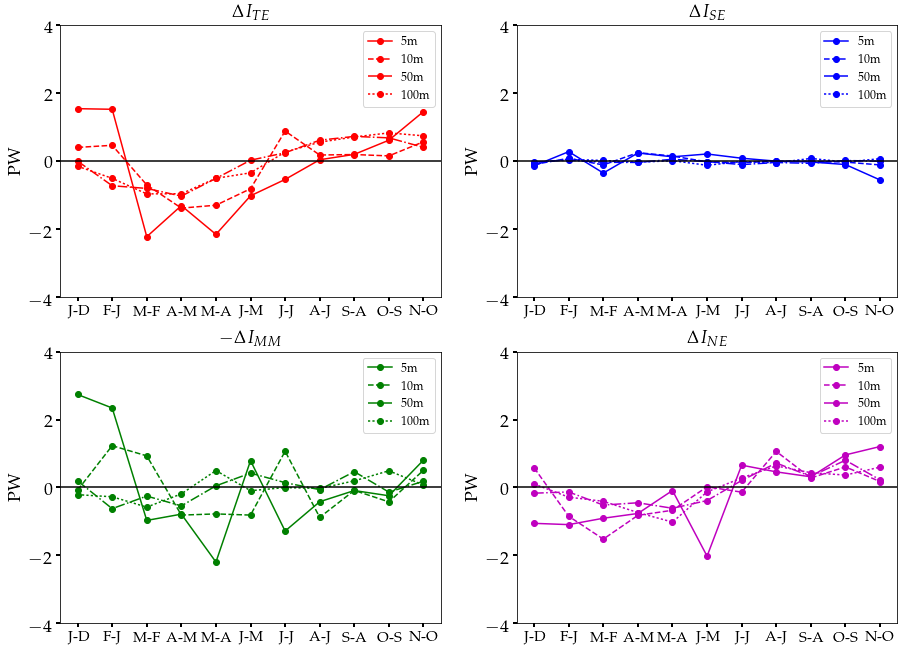

In [135]:
fig=py.figure(figsize=(15, 11))
compare_plot(1,Intensity_teN,'r',r'$\Delta I_{TE}$',l=4)
compare_plot(2,-Intensity_seN,'b',r'$\Delta I_{SE}$',l=4)
compare_plot(3,-Intensity_mmN,'g',r'$ - \Delta I_{MM}$',l=4)
compare_plot(4,Intensity_neN,'m',r'$\Delta I_{NE}$',l=4)

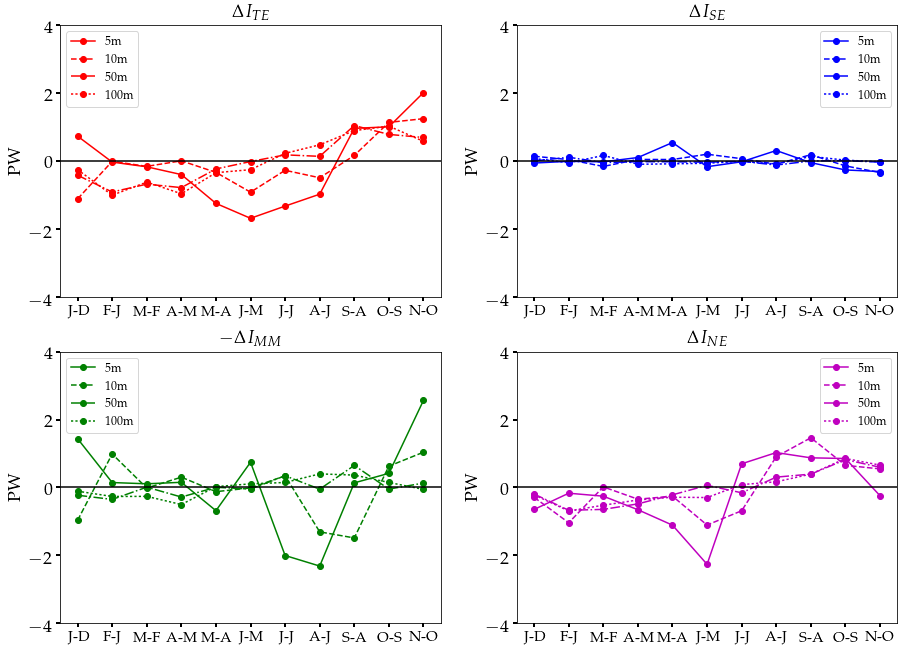

In [136]:
fig=py.figure(figsize=(15, 11))
compare_plot(1,Intensity_teS,'r',r'$\Delta I_{TE}$',l=4)
compare_plot(2,-Intensity_seS,'b',r'$\Delta I_{SE}$',l=4)
compare_plot(3,-Intensity_mmS,'g',r'$ - \Delta I_{MM}$',l=4)
compare_plot(4,Intensity_neS,'m',r'$\Delta I_{NE}$',l=4)

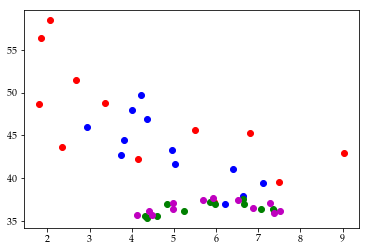

In [64]:
d=0
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'ro')
d=1
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'bo')
d=2
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'go')
d=3
py.plot(Intensity_teN[d,:],storm_pos_N[d,:],'mo')

In [65]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_intensity(d,N):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    fig=py.figure(figsize=(15, 9))        
    if N==1 :    
        py.plot(D(Intensity_teN,d),'ro-',label=r'$\Delta I$',lw=2.5)
        py.plot(D(Intensity_neN,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)   
        py.plot(-D(Intensity_seN,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
        py.plot(-D(Intensity_mmN,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
             
    if N==-1 :
        py.plot(D(Intensity_teS,d),'ro-',label=r'$\Delta I$',lw=2.5)
        py.plot(D(Intensity_neS,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
        py.plot(-D(Intensity_seS,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
        py.plot(-D(Intensity_mmS,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
                                 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-3,3)
    py.ylabel("PW", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
    title="Intensity decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/Intensity_decomposition_NH_5m.pdf


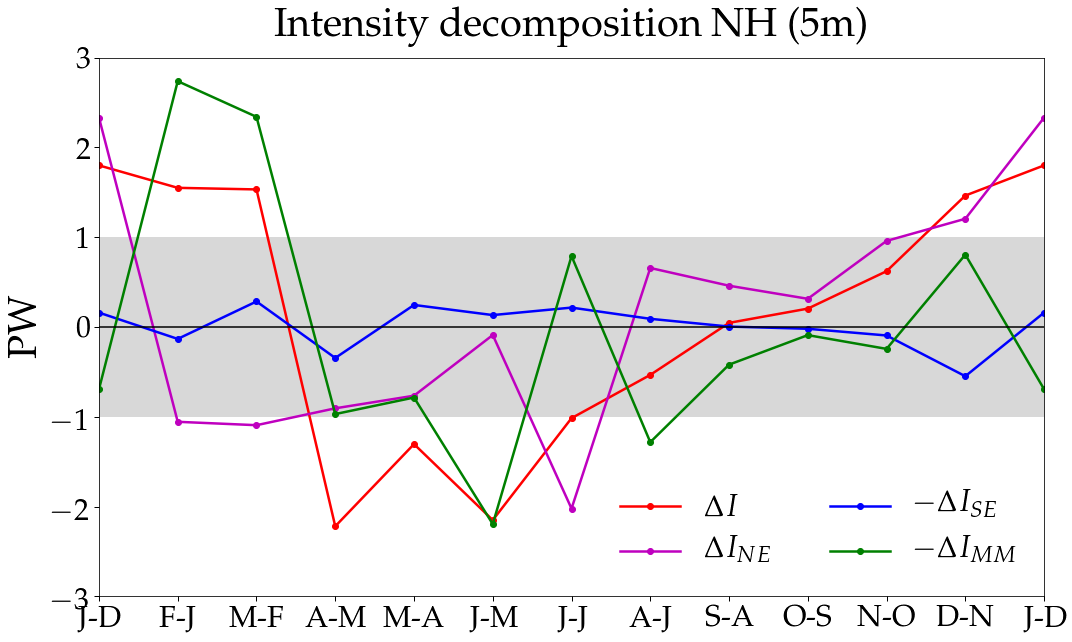

In [66]:
d=0
plot_intensity(d,1)

In [67]:
SE_change=np.zeros((4,len(lat),13))
MM_change=np.zeros((4,len(lat),13))
TE_change=np.zeros((4,len(lat),13))
NE_change=np.zeros((4,len(lat),13))

def calculate_shift_just_by_adding_individual_flux_divergences():
    
    se=div_SE; te=div_TE; mm=div_MM; ne=div_NE
    
    div_se=np.append(se,se[:,:,0,np.newaxis],axis=2)
    div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=2)
    div_te=np.append(te,te[:,:,0,np.newaxis],axis=2)
    div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=2)
    
    for month in range(0,12):

        del_div_SE1=div_se[:,:,month+1]-div_se[:,:,month]
        del_div_MM1=div_mm[:,:,month+1]-div_mm[:,:,month]
        del_div_TE1=div_te[:,:,month+1]-div_te[:,:,month]
        del_div_NE1=div_ne[:,:,month+1]-div_ne[:,:,month]
        
        SE_change[:,:,month+1]=te[:,:,month]-del_div_SE1
        MM_change[:,:,month+1]=te[:,:,month]-del_div_MM1
        TE_change[:,:,month+1]=te[:,:,month]+del_div_TE1
        NE_change[:,:,month+1]=te[:,:,month]+del_div_NE1

    SE_change[:,:,0]=SE_change[:,:,12]
    TE_change[:,:,0]=TE_change[:,:,12]
    MM_change[:,:,0]=MM_change[:,:,12]
    NE_change[:,:,0]=NE_change[:,:,12]
    return SE_change, MM_change, TE_change, NE_change

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences()

In [68]:
# storm_pos_N=np.zeros((4,12)) ; storm_pos_S=np.zeros((4,12));
# for d in range(4):
#     storm_pos_N[d,:]=find_zero(div_TE[d,...],+1)
#     storm_pos_S[d,:]=find_zero(div_TE[d,...],-1)


from scipy.interpolate import interp1d
def find_zero(div,N=1):
  zero_loc = np.zeros(13)
  for m in range(0,13):
        if N==1 :
         l_range=((lat>=32) & (lat<=70))            
        else    :
         l_range=((lat>=-70) & (lat<=-32))                    
        interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
        try :
            zero_loc[m]=interpolation_function(0)
        except ValueError as err:
            zero_loc[m]=np.nan

        
  return zero_loc

def plot_monthly_shift_method2(N,d) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    zero_div_TE=find_zero(TE_change[d,...],N)
    zero_div_SE=find_zero(SE_change[d,...],N)
    zero_div_MM=find_zero(MM_change[d,...],N)
    zero_div_NE=find_zero(NE_change[d,...],N)

    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y

    TE_obs         = add_month_to_end(zero_div_TE[1:]-zero_div_TE[:-1] )
    SE             = add_month_to_end(zero_div_SE[1:]-zero_div_TE[:-1])
    MM             = add_month_to_end(zero_div_MM[1:]-zero_div_TE[:-1])
    NE             = add_month_to_end(zero_div_NE[1:]-zero_div_TE[:-1])
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\delta\: (\textrm{obs})$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\delta_{\textrm{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\delta_{\textrm{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\delta_{\textrm{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'$\textrm{error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    #mticks = [r'$\textrm{J-D}$',r'$\textrm{F-J}$',r'$\textrm{M-F}$',r'$\textrm{A-M}$',r'$\textrm{M-A}$', r'$\textrm{J-M}$',r'$\textrm{J-J}$',r'$\textrm{A-J}$', r'$\textrm{S-A}$', r'$\textrm{O-S}$', r'$\textrm{N-O}$', r'$\textrm{D-N}$', r'$\textrm{J-D}$']
    py.xlim(0,12)
    py.ylim(-14,14)
    #py.ylabel(r"\textrm{Poleward\hspace{ 2mm} Shift \hspace{ 2mm}}$(^{o}\:N)$", fontsize=45)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
        
    title="storm track decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

(13,)
         err    shiftEI    shiftMM   shiftSE  shiftTE_obs
0        NaN        NaN  -1.766524 -3.524281    -4.989586
1   1.180988  -1.520474   3.024258 -0.312849     2.371923
2  -0.245606   0.531133   3.063193  0.006902     3.355621
3   0.436741   1.173767   0.888108 -0.151434     2.347182
4   0.071327   0.626004   0.093555 -0.444429     0.346457
5   0.659016   0.469509   1.782539  0.166594     3.077658
6  -0.696875   2.024767  -7.064640  0.625019    -5.111730
7  -0.997360  -0.447009  11.102895 -4.595892     5.062634
8  -1.439749   3.756054   8.063800 -2.770555     7.609550
9   1.205933  -2.836557   2.965326  0.780196     2.114898
10  9.367793 -13.252464  -2.352596 -0.668139    -6.905406
11  0.190210  -1.657312  -7.567006 -0.245094    -9.279202
12       NaN        NaN  -1.766524 -3.524281    -4.989586


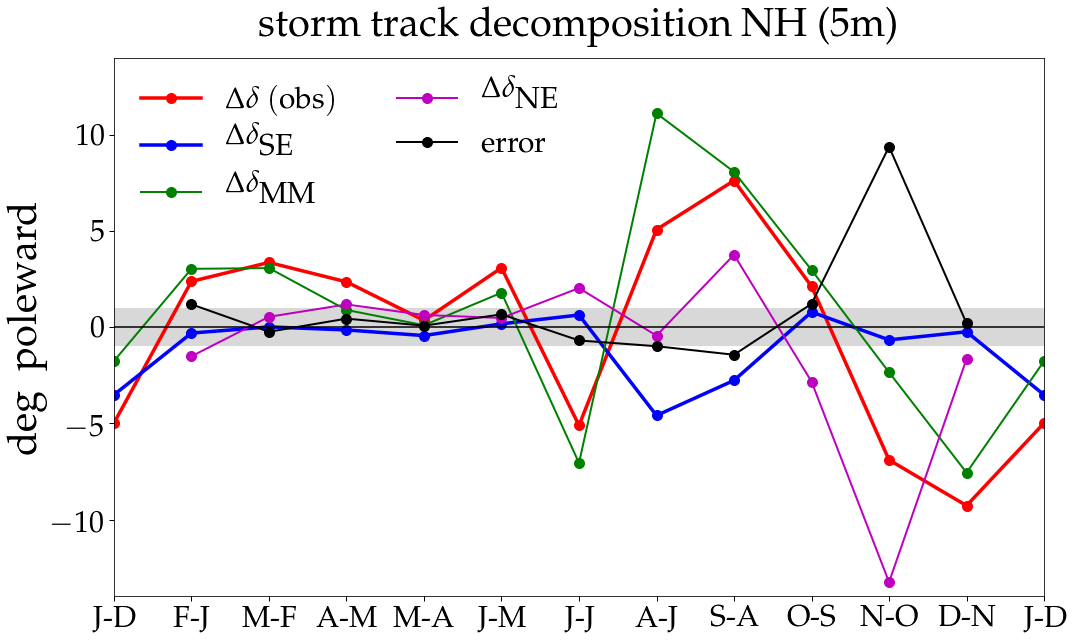

In [69]:
d=0
plot_monthly_shift_method2(1,d)

(13,)
         err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0  -0.750790 -0.549829 -1.805311 -0.203252    -3.309181
1   0.058217  1.078140  1.433993 -1.461643     1.108707
2   1.581802  2.120815 -5.885840 -2.291110    -4.474333
3  -0.029288  0.863499 -1.756302 -0.330835    -1.252926
4  -1.652646  3.190085  0.737054  0.506855     2.781348
5   0.482680  0.286706  2.271448  0.821705     3.862538
6  -3.110248  0.645659  7.468078  1.726618     6.730107
7        NaN       NaN -3.294477  1.629534    -0.184111
8  -0.142206 -0.783201 -0.918278  0.976298    -0.867386
9  -0.200823 -0.486516 -1.080447 -0.317879    -2.085665
10 -1.413690 -1.650887  1.194007 -0.287671    -2.158242
11 -0.429663 -0.182839  0.729015 -0.267368    -0.150855
12 -0.750790 -0.549829 -1.805311 -0.203252    -3.309181


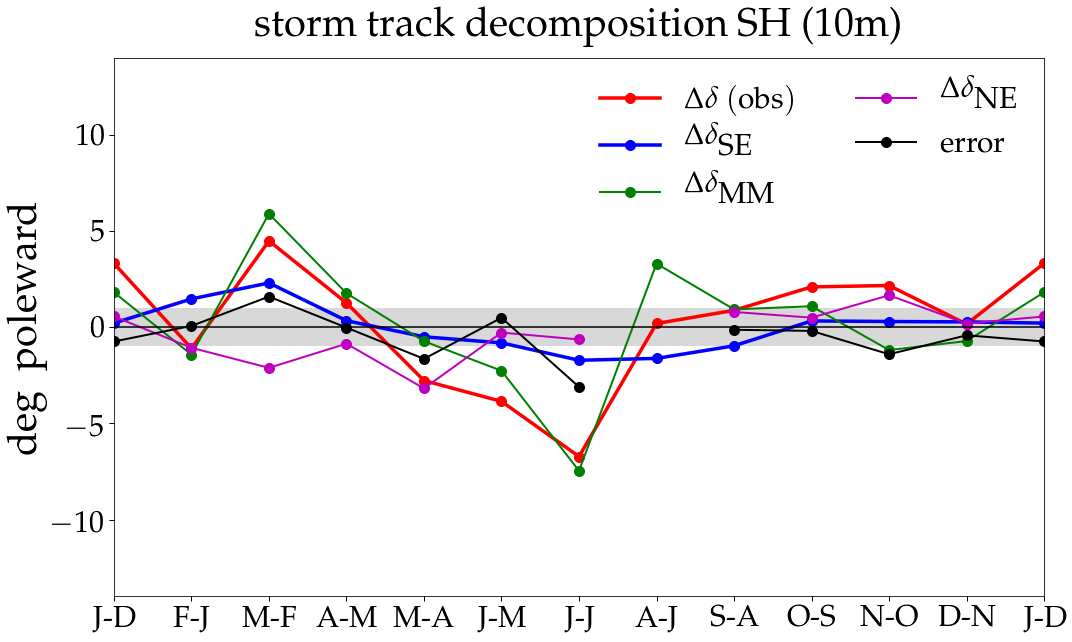

In [70]:
d=d+1
plot_monthly_shift_method2(-1,d)

# Try decomposing by calculating the shift from mean values

In [137]:
SE_change=np.zeros((4,len(lat),12))
MM_change=np.zeros((4,len(lat),12))
TE_change=np.zeros((4,len(lat),12))
NE_change=np.zeros((4,len(lat),12))

def calculate_changes_from_mean():
    
    se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)
    
#     div_se=np.append(se,se[:,:,0,np.newaxis],axis=2)
#     div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=2)
#     div_te=np.append(te,te[:,:,0,np.newaxis],axis=2)
#     div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=2)

    for month in range(0,12):

        del_div_SE1=se[:,:,month]-se.mean(axis=-1)
        del_div_MM1=mm[:,:,month]-mm.mean(axis=-1)
        del_div_TE1=te[:,:,month]-te.mean(axis=-1)
        del_div_NE1=ne[:,:,month]-ne.mean(axis=-1)
        
        SE_change[:,:,month]=te.mean(axis=-1)-del_div_SE1
        MM_change[:,:,month]=te.mean(axis=-1)-del_div_MM1
        TE_change[:,:,month]=te.mean(axis=-1)+del_div_TE1
        NE_change[:,:,month]=te.mean(axis=-1)+del_div_NE1

    return SE_change, MM_change, TE_change, NE_change

SE_change, MM_change, TE_change, NE_change = calculate_changes_from_mean()

0


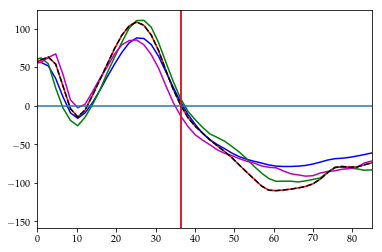

In [138]:
d=2;
m=0;
py.plot(lat,TE_change[d,:,m],'r-')
py.plot(lat,SE_change[d,:,m],'b-')
py.plot(lat,MM_change[d,:,m],'g-')
py.plot(lat,NE_change[d,:,m],'m-')
py.plot(lat,div_TE[d][:,m],'k--')
py.xlim(0,85)
#py.ylim(-125,125)
py.axhline(0)
py.axvline(storm_pos_N[d,:].mean())
py.axvline(storm_pos_N[d,m],color='r')
print m

In [139]:
d=0
print storm_pos_N[d,:].mean()

def find_zero(div,N=1):
        if N==1 :
         l_range=((lat>=35) & (lat<=70))            
        else    :
         l_range=((lat>=-70) & (lat<=-35))                    
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan
        
        return zero_loc

print find_zero(TE_change[d,...].mean(axis=-1),N=1)

46.7010359623
44.4640125557


In [150]:
from scipy.interpolate import interp1d

def find_zero(div,N=1,mean='no'):   
  if N==1 :
     l_range=((lat>=35) & (lat<=70))            
  if N==-1:
    l_range=((lat>=-70) & (lat<=-32))  
    
  if mean == 'no' :
      zero_loc = np.zeros(12)
      for m in range(0,12): 
            if N==1 :
                interpolation_function = interp1d(div[l_range,m],lat[l_range],kind='linear')
            if N==-1 :
                interpolation_function = interp1d(div[l_range,m][::-1],lat[l_range][::-1],kind='linear')
            try :
                zero_loc[m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[m]=np.nan
  if mean == 'yes' :
                   
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan
            
  return zero_loc

def plot_shift_from_mean_method2(N,d,l) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    zero_div_TE=find_zero(TE_change[d,...],N)
    zero_div_SE=find_zero(SE_change[d,...],N)
    zero_div_MM=find_zero(MM_change[d,...],N)
    zero_div_NE=find_zero(NE_change[d,...],N)
    
    mean_pos_TE=find_zero(TE_change[d,...].mean(axis=-1),N,mean='yes')
    
    print mean_pos_TE
    
    if N==1 :
        I=Intensity_teN
    if N==-1 :
        I=Intensity_teS
        
    def threshold(I, pos1, pos2, pos3, pos4):
        I=np.append(I[-1],I)
        for m in range(13):
            if (np.abs(I[m])<+1) :
                #N[d,m]=np.nan
                pos1[m]=np.nan
                pos2[m]=np.nan
                pos3[m]=np.nan
                pos4[m]=np.nan                
        return pos1, pos2, pos3, pos4

    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I[d,:], zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE )
                
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1,y1[0])
        return y

    TE_obs         = add_month_to_end(zero_div_TE-mean_pos_TE)
    SE             = add_month_to_end(zero_div_SE-mean_pos_TE)
    MM             = add_month_to_end(zero_div_MM-mean_pos_TE)
    NE             = add_month_to_end(zero_div_NE-mean_pos_TE)
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    #print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\phi_{ ({obs})}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    #mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    #py.ylabel(r"\textrm{Poleward\hspace{ 2mm} Shift \hspace{ 2mm}}$(^{o}\:N)$", fontsize=45)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"
        
    title="shift decomposition about mean"+" "+H+" ("+str(depth)+"m)"
    title1="shift_decomp_about_mean"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ECHAM/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ECHAM/"
    py.savefig(fig_dest1+title1+'.pdf')
    py.show()

-42.20474506
         err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0  -5.086198 -4.600466  6.133052  0.075522    -3.478089
1   0.364330 -3.446798  1.617822 -0.904736    -2.369382
2  -1.145471 -0.597359 -4.714972 -0.385913    -6.843716
3   0.599741  0.321633 -6.180379 -2.837637    -8.096642
4  -0.510058  1.985220 -4.374381 -2.416075    -5.315294
5  -0.382371  2.341273 -1.670027 -1.741630    -1.452755
6  -1.420456  1.848111  4.964757 -0.115061     5.277352
7  -2.953817  6.397383  0.013680  1.635994     5.093240
8  -4.180828  3.689256  2.247290  2.470135     4.225854
9  -1.095186  0.633506  1.152038  1.449830     2.140188
10  0.984448 -3.184344  1.290185  0.891658    -0.018053
11 -1.928465 -2.839263  4.206168  0.392652    -0.168908
12 -5.086198 -4.600466  6.133052  0.075522    -3.478089


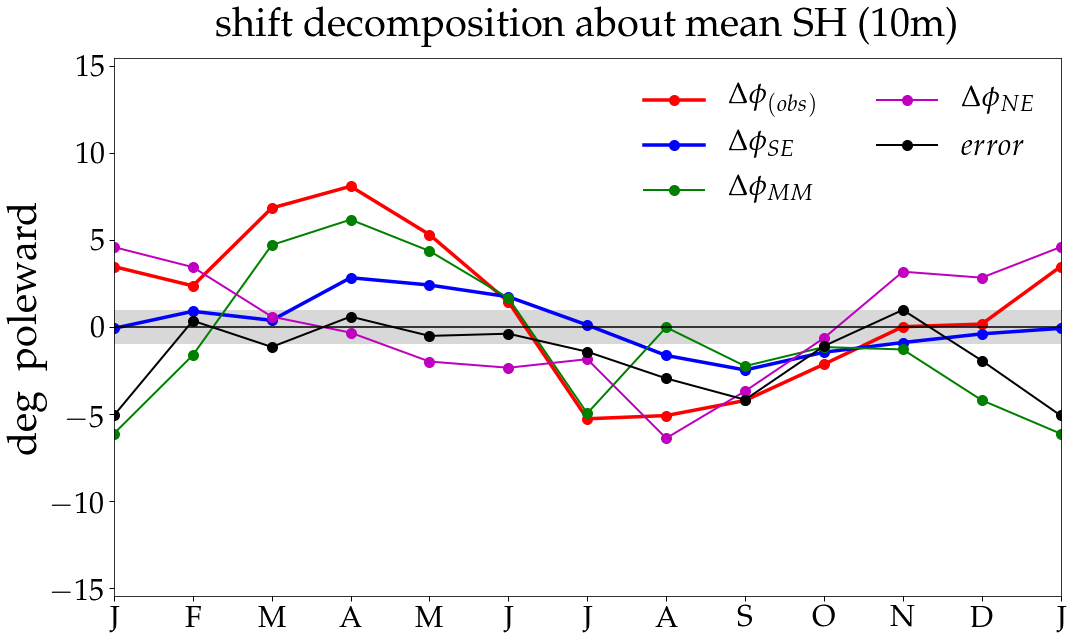

In [156]:
d=1; 
l=15.5;
N=-1
plot_shift_from_mean_method2(N,d,l)

44.4640125557
         err   shiftEI    shiftMM   shiftSE  shiftTE_obs
0   0.192912 -5.599459  -1.319117 -0.489224    -7.214888
1        NaN       NaN  -2.635683  0.647408    -4.842965
2   4.807601 -6.876595  -0.495296  1.076945    -1.487344
3  -0.086434 -0.229179   0.704476  0.470975     0.859838
4  -0.367946  1.569674   0.644918 -0.640351     1.206295
5   0.759953  2.371809   1.458204 -0.306012     4.283953
6        NaN  4.172815        NaN  0.290621    -0.827777
7   4.817411  2.172999  -2.619710 -0.135843     4.234858
8   3.069731  4.298444   5.596114 -1.119880    11.844408
9   1.550633  2.707241  10.789091 -1.087659    13.959306
10 -0.552720 -1.223953   8.336105  0.494468     7.053900
11 -1.944697 -2.825194   1.436522  1.108068    -2.225302
12  0.192912 -5.599459  -1.319117 -0.489224    -7.214888


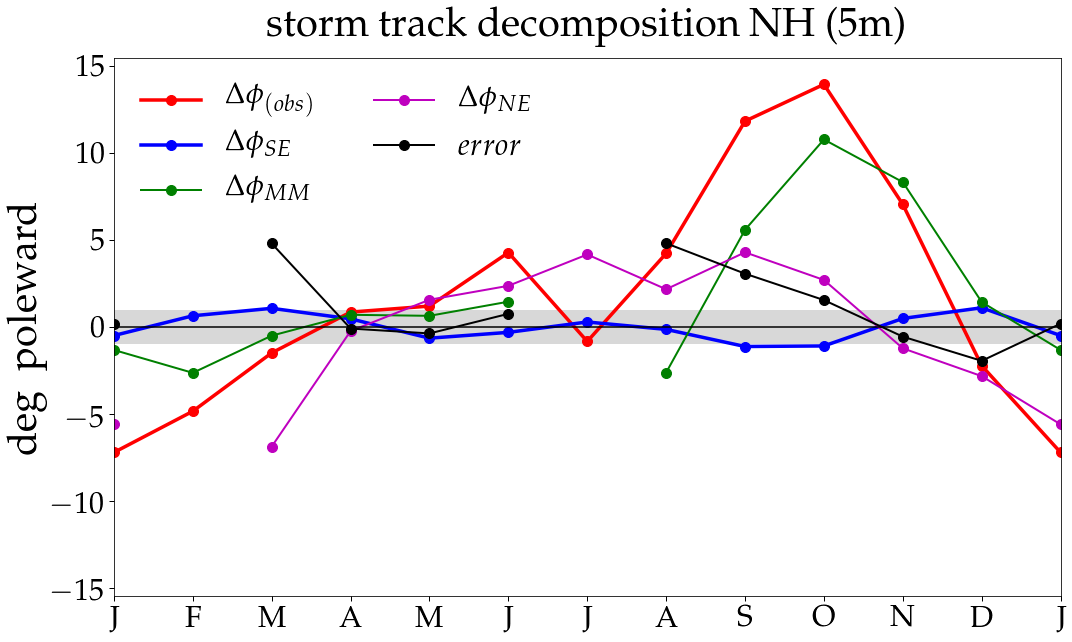

In [96]:
d=0; 
l=15.5;
N=1
plot_shift_from_mean_method2(N,d,l)

# Average Northern and Southern Hemispheres

In [49]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(TE+MM+SE)
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
Iswabs_clsky=np.array(Iswabs_clsky); Ishf_clsky=np.array(Ishf_clsky); Ine_clsky=np.array(Ine_clsky); Iolr_clsky=np.array(Iolr_clsky); Idhdt_clsky=np.array(Idhdt_clsky); 

In [50]:
sfc_temp_water=np.zeros((4,96,12)); sfc_temp_land=np.copy(sfc_temp_water); 
sfc_temp=np.copy(sfc_temp_water); temp_2m=np.copy(sfc_temp_water); 
u_10m=np.copy(sfc_temp_water); v_10m =np.copy(sfc_temp_water); 

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    sfc_temp_water[i,...], sfc_temp_land[i,...], sfc_temp[i,...], temp_2m[i,...], u_10m[i,...], v_10m[i,...]  = temp_and_wind(X[i])

lat=m5_nc['lat'][:]

KeyboardInterrupt: 

In [52]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:]+flux_flag*np.roll(x[:,l_S,:][:,::-1,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[:,:,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [53]:
TE_a   ,SE_a     , MM_a   , NE_a     ,ignore,  lat_a = N_S_avg(TE, SE, MM, NE,NE, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a,    Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
Iswabs_a_clsky,Ishf_a_clsky  , Ine_a_clsky , Iolr_a_clsky,    Idhdt_a_clsky, latr_a = N_S_avg( Iswabs_clsky,Ishf_clsky,Ine_clsky,Iolr_clsky,Idhdt_clsky, lat[1:-1])
#sfc_temp_water_a, sfc_temp_land_a, sfc_temp_a, temp_2m_a, ignore, lat_a= N_S_avg(sfc_temp_water, sfc_temp_land, sfc_temp, temp_2m, temp_2m, lat,flux_flag=1)


In [54]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x):
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(4):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a = spher_div(TE_a*10**15)
div_SE_a = spher_div(SE_a*10**15)
div_MM_a = spher_div(MM_a*10**15)
div_NE_a = div_TE_a+div_SE_a+div_MM_a

In [55]:
#lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((4,13))
  for d in range(0,4):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [56]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)


I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWAB_clsky =inerp_at_max(Iswabs_a_clsky,latr_a)
I_SHF_clsky  =inerp_at_max(Ishf_a_clsky,latr_a)
I_NE_clsky   =inerp_at_max(Ine_a_clsky,latr_a)
I_OLR_clsky  =inerp_at_max(Iolr_a_clsky,latr_a)
I_dhdt_clsky =inerp_at_max(Idhdt_a_clsky,latr_a)

## Shift decompose

In [57]:
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1)

In [58]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=65))   
            if (d<2):
                l_range=((lat_a>=35) & (lat_a<=65))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [59]:
def threshold(I,value, pos1, pos2, pos3, pos4):
      for d in range(4):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                #N[d,m]=np.nan
                pos1[d,m]=np.nan
                pos2[d,m]=np.nan
                pos3[d,m]=np.nana
                pos4[d,m]=np.nan                
      return pos1, pos2, pos3, pos4
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, 1.0, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))

In [60]:
def plot_flux(d,threshold_value) :
    
    n=d+1
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    pos=zero_div_TE
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100

    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def add(y):
       y1 = y#np.append(y,y[:,0,np.newaxis],axis=1)
       return y1    
    
    def a(y):
       y1 = y#np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, threshold_value)
    latns=lat

    py.subplot(220+n)
    b = py.contourf(range(13),lat_a,add(TE_a[d,...]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),lat_a, add(TE_a[d,...]), v, colors='k',linewidths=1.0);
    
    py.plot(range(13), (pos[d,:]), 'ro-')
    #py.plot(range(13), (Intensity_te[d,:]*5), 'bo-')
    
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-0,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.ylim(0,60)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

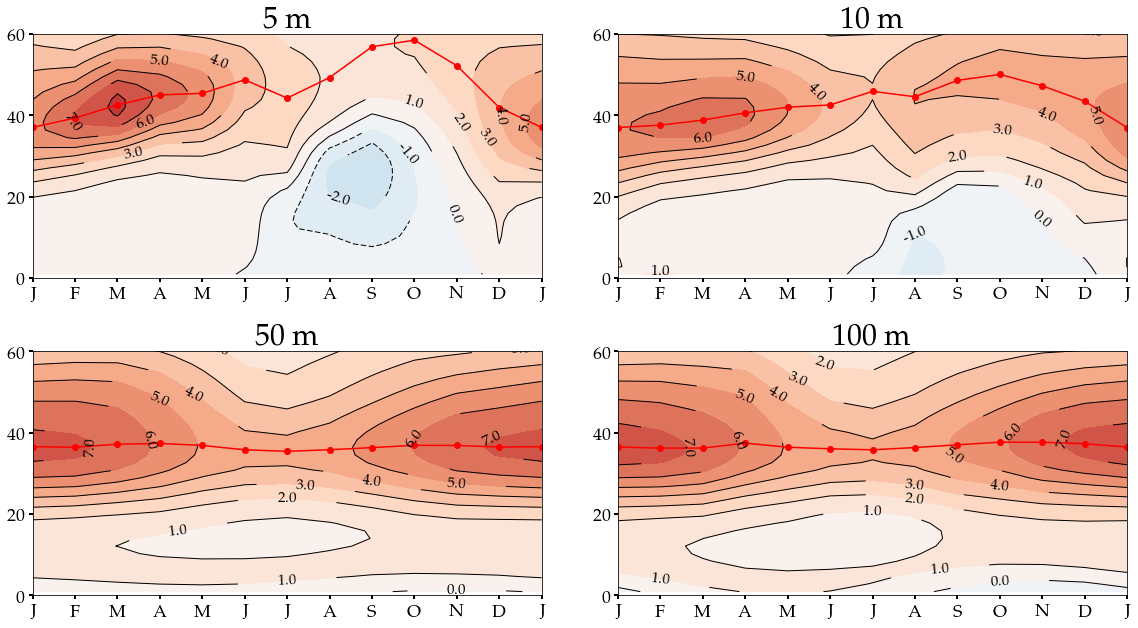

In [61]:
fig=py.figure(figsize=(20, 10))
for d in range(4):
    plot_flux(d,1.0)

In [62]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=1,threshold_value=+1) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
            
    I=Intensity_te
    
    n=d+1    
#     month_to_month=1
#     threshold_value=0
    SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    
    if ((d==0) & (month_to_month==0)):
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,40,5), find_zero(NE_change,35,0))
    
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))
    
    
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=find_zero(s)
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
        print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    SE_pos             = add_month_to_end(zero_div_SE[d,1:]-base_pos)
    MM_pos             = add_month_to_end(zero_div_MM[d,1:]-base_pos)
    NE_pos             = add_month_to_end(zero_div_NE[d,1:]-base_pos)
    TE_calc_pos        = SE_pos+MM_pos+NE_pos
    nonlinear_error= TE_obs_pos-TE_calc_pos
        
#     py.subplot(220+n)
    
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi_{ ({obs})}$',linewidth=3.5,markersize=20)
    fig=py.plot(SE_pos,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(MM_pos,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(NE_pos,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)

    title="shift decomposition threshold"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp_threshold"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

[[ 42.10028309]]


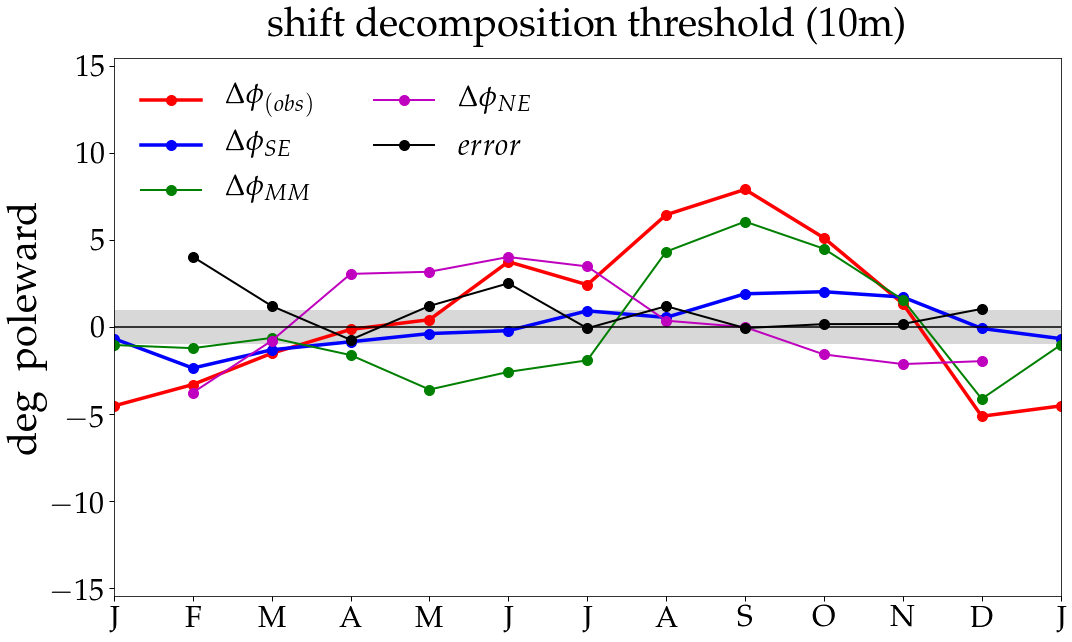

In [63]:
l=15.5
month_to_month=0; threshold_value=+1.0
plot_monthly_shift(1,l,month_to_month,threshold_value)

# Intensity decomposition

In [64]:
### radiation

def plot_intensity(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=2.5)
    py.plot(D(Intensity_ne,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)   
    py.plot(-D(Intensity_se,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
    py.plot(-D(Intensity_mm,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
                                              
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="Intensity decomposition"+" "+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/Intensity_decomposition__100m.pdf


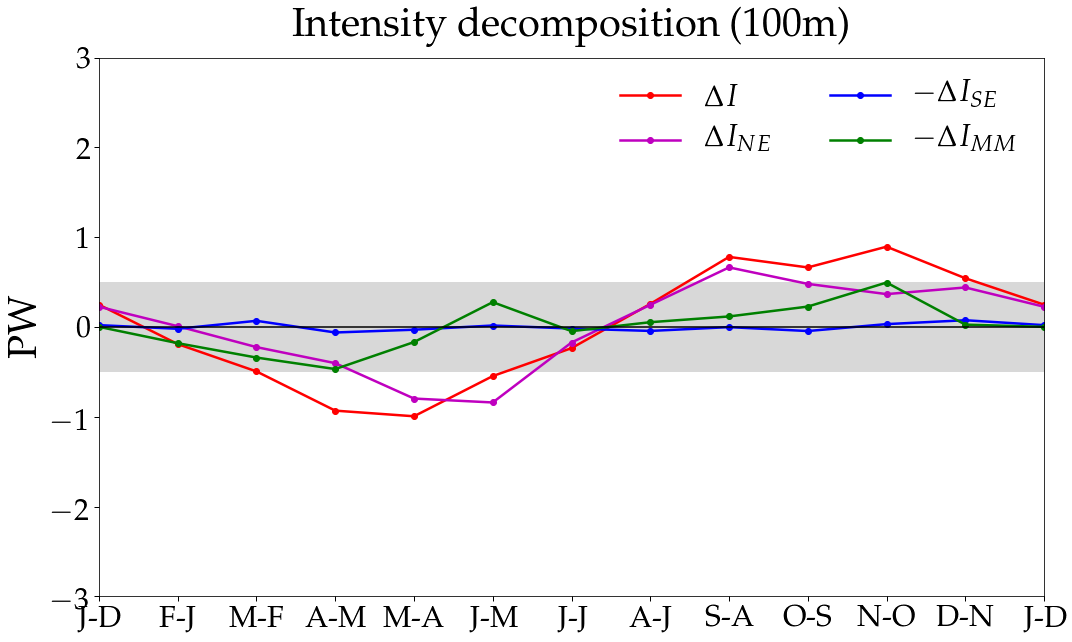

In [65]:
plot_intensity(3,3,1)

In [66]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_delta_NE(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
      
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(I_NE,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
    py.plot(D(I_SWAB,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
    py.plot(D(I_SHF,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
    py.plot(D(I_OLR,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="NE decomposition"+" "+" ("+str(depth)+"m)"
    title1="NE_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=2,frameon=False, loc='best')
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/NE_decomposition__50m.pdf


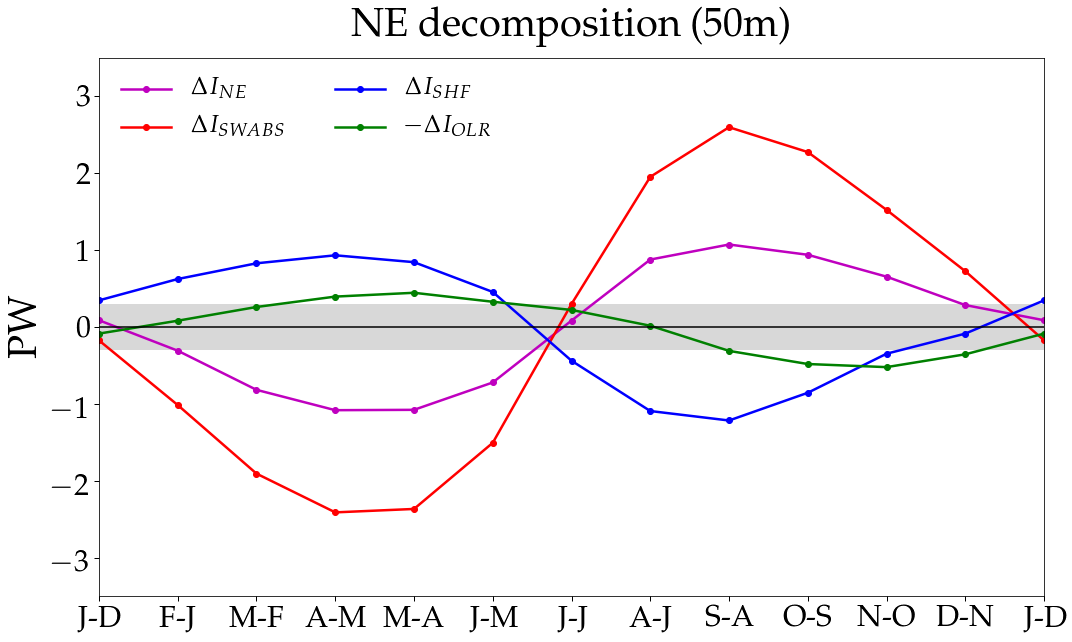

In [67]:
plot_delta_NE(2,3.5,1)

In [68]:
### radiation

def plot_delta_NE_clsky(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
      
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(I_NE_clsky,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
    py.plot(D(I_SWAB_clsky,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
    py.plot(D(I_SHF_clsky,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
    py.plot(D(I_OLR_clsky,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="NE decomposition"+" "+" ("+str(depth)+"m)"
    title1="NE_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=2,frameon=False, loc='best')
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'   
    py.tight_layout()

In [69]:
# d=0
# plot_delta_NE_clsky(d,10.5,0)

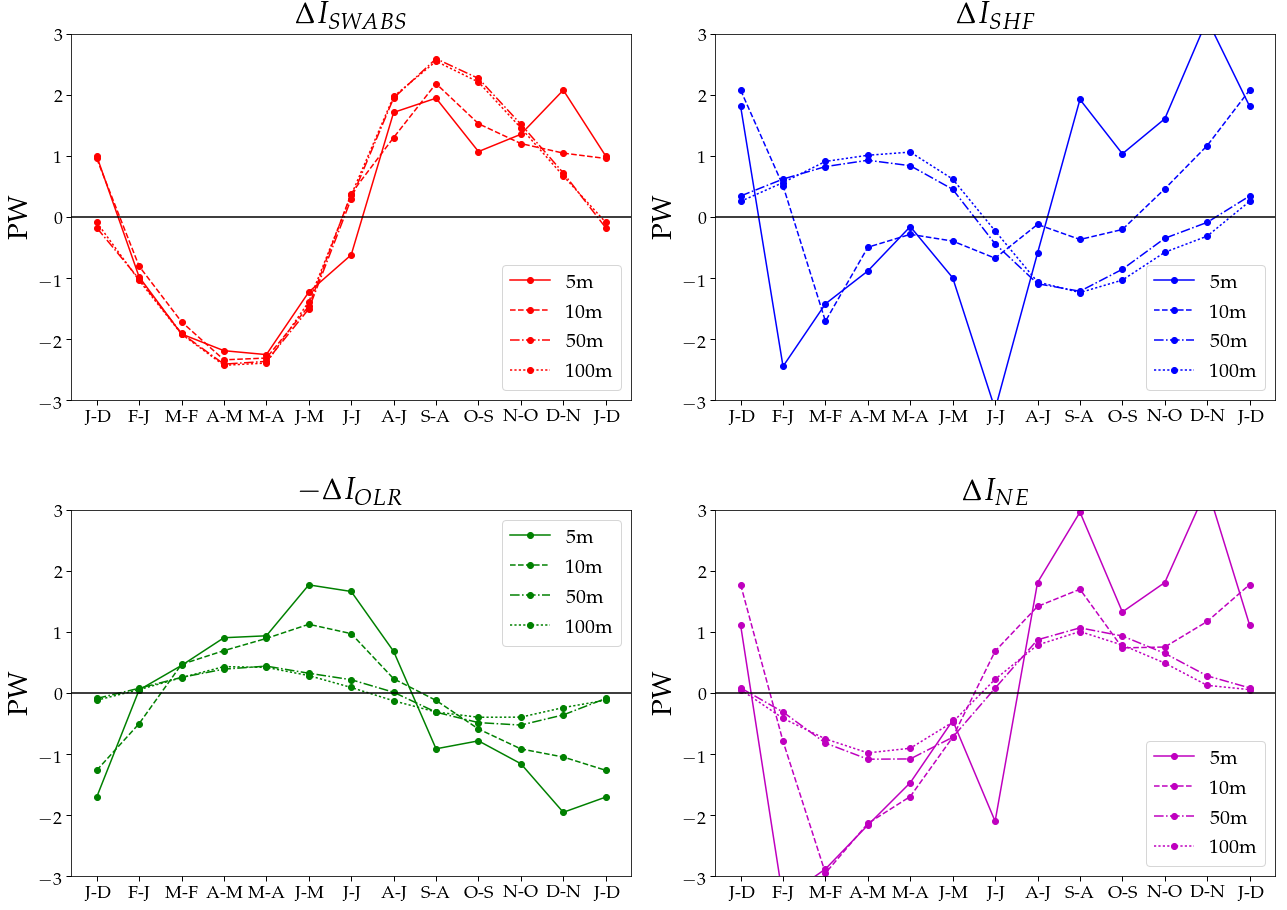

In [70]:
def compare_plot(n,X,c,T,month_to_month=1,l=3):
    py.subplot(220+n)
    d=0
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
    py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
    py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
    py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel('PW',fontsize=28)
    py.legend(loc='best',fontsize=20)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=30)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=18,size=5,width=1)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)


fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$')
compare_plot(2,I_SHF,'b',r'$\Delta I_{SHF}$')
compare_plot(3,I_OLR,'g',r'$ - \Delta I_{OLR}$')
compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$')


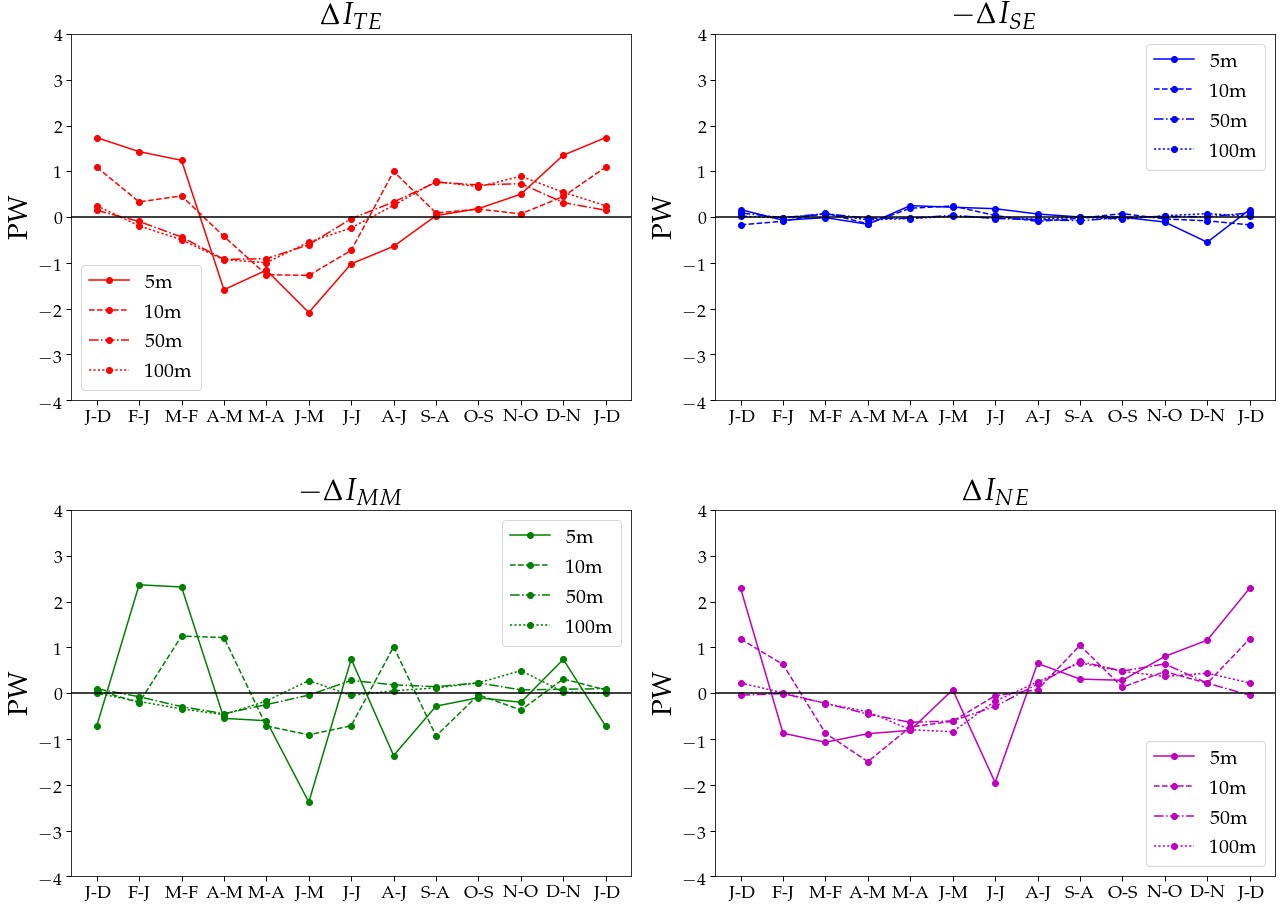

In [71]:
fig=py.figure(figsize=(22, 15))
compare_plot(1,Intensity_te,'r',r'$\Delta I_{TE}$',l=4)
compare_plot(2,-Intensity_se,'b',r'$ - \Delta I_{SE}$',l=4)
compare_plot(3,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',l=4)
compare_plot(4,Intensity_ne,'m',r'$\Delta I_{NE}$',l=4)

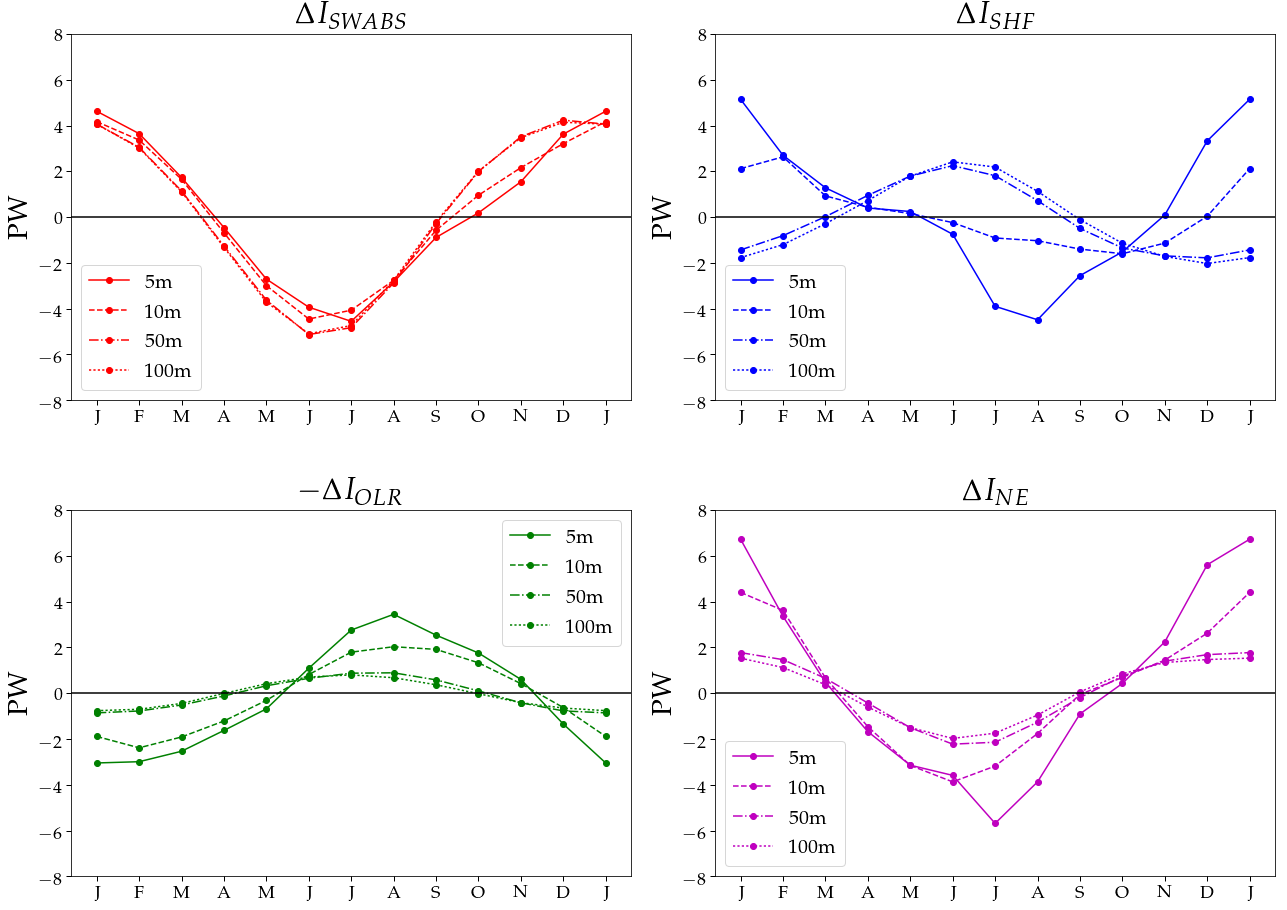

In [72]:
m_to_m=0; l=8
fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(2,I_SHF,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(3,I_OLR,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$',m_to_m,l)


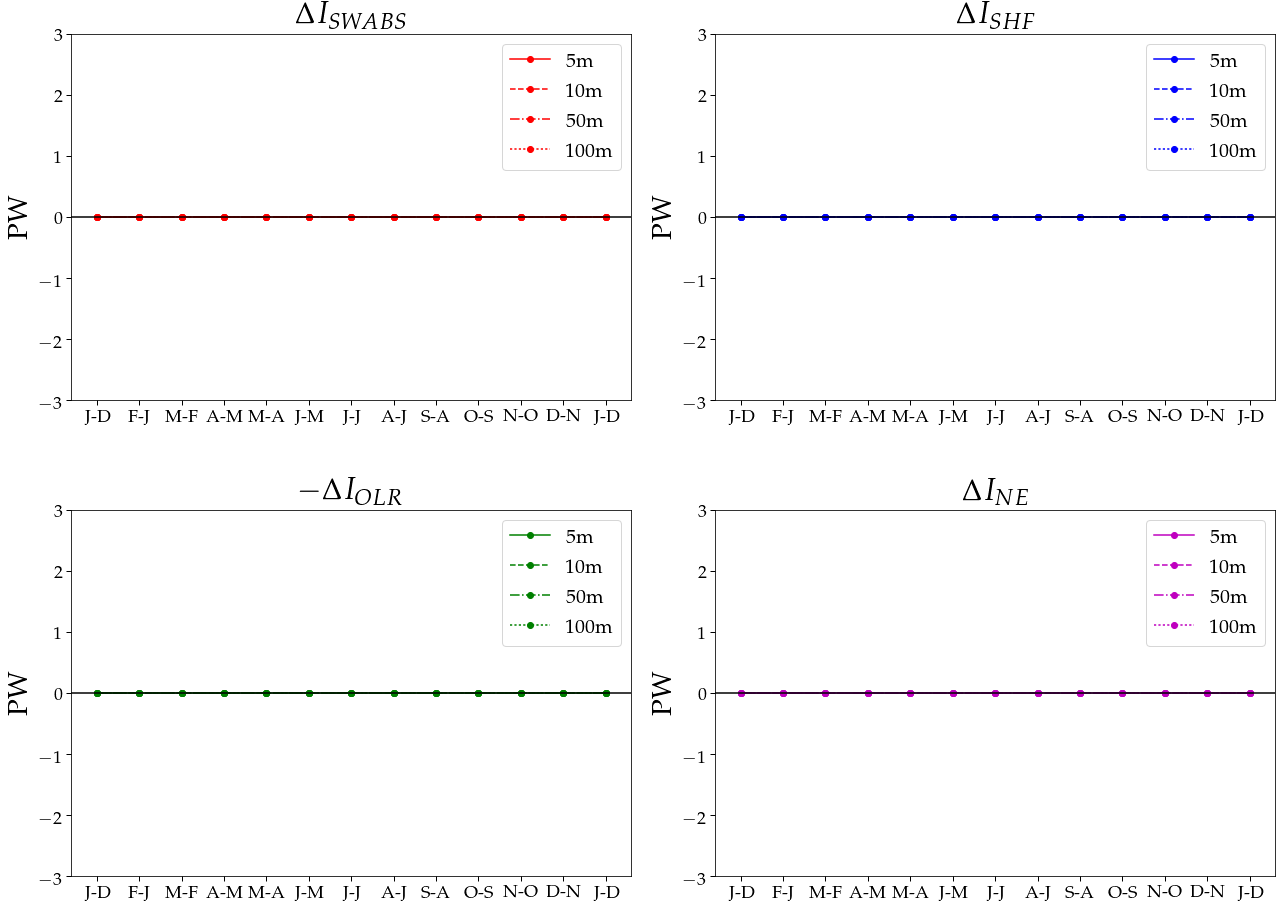

In [73]:
m_to_m=1; l=3
fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB_clsky,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(2,I_SHF_clsky,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(3,I_OLR_clsky,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
compare_plot(4,I_NE_clsky,'m',r'$\Delta I_{NE}$',m_to_m,l)


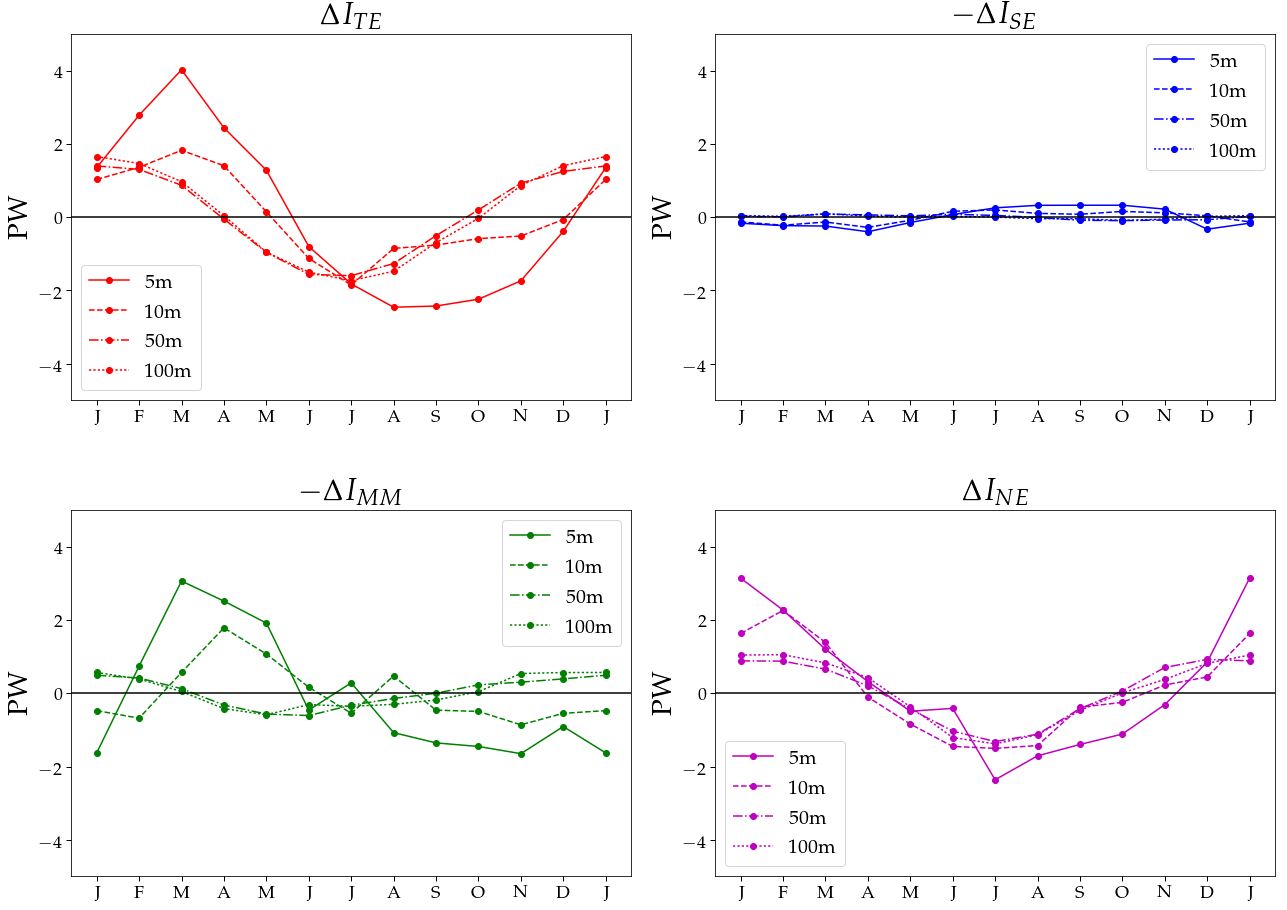

In [74]:
m_to_m=0; l=5
fig=py.figure(figsize=(22, 15))
compare_plot(1,Intensity_te,'r',r'$\Delta I_{TE}$',m_to_m,l)
compare_plot(2,-Intensity_se,'b',r'$ - \Delta I_{SE}$',m_to_m,l)
compare_plot(3,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',m_to_m,l)
compare_plot(4,Intensity_ne,'m',r'$\Delta I_{NE}$',m_to_m,l)

In [75]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_40(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=40
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D


I_SWAB_at40 =inerp_at_40(Iswabs_a,latr_a)
I_SHF_at40  =inerp_at_40(Ishf_a,latr_a)
I_NE_at40   =inerp_at_40(Ine_a,latr_a)
I_OLR_at40  =inerp_at_40(Iolr_a,latr_a)
I_dhdt_at40 =inerp_at_40(Idhdt_a,latr_a)

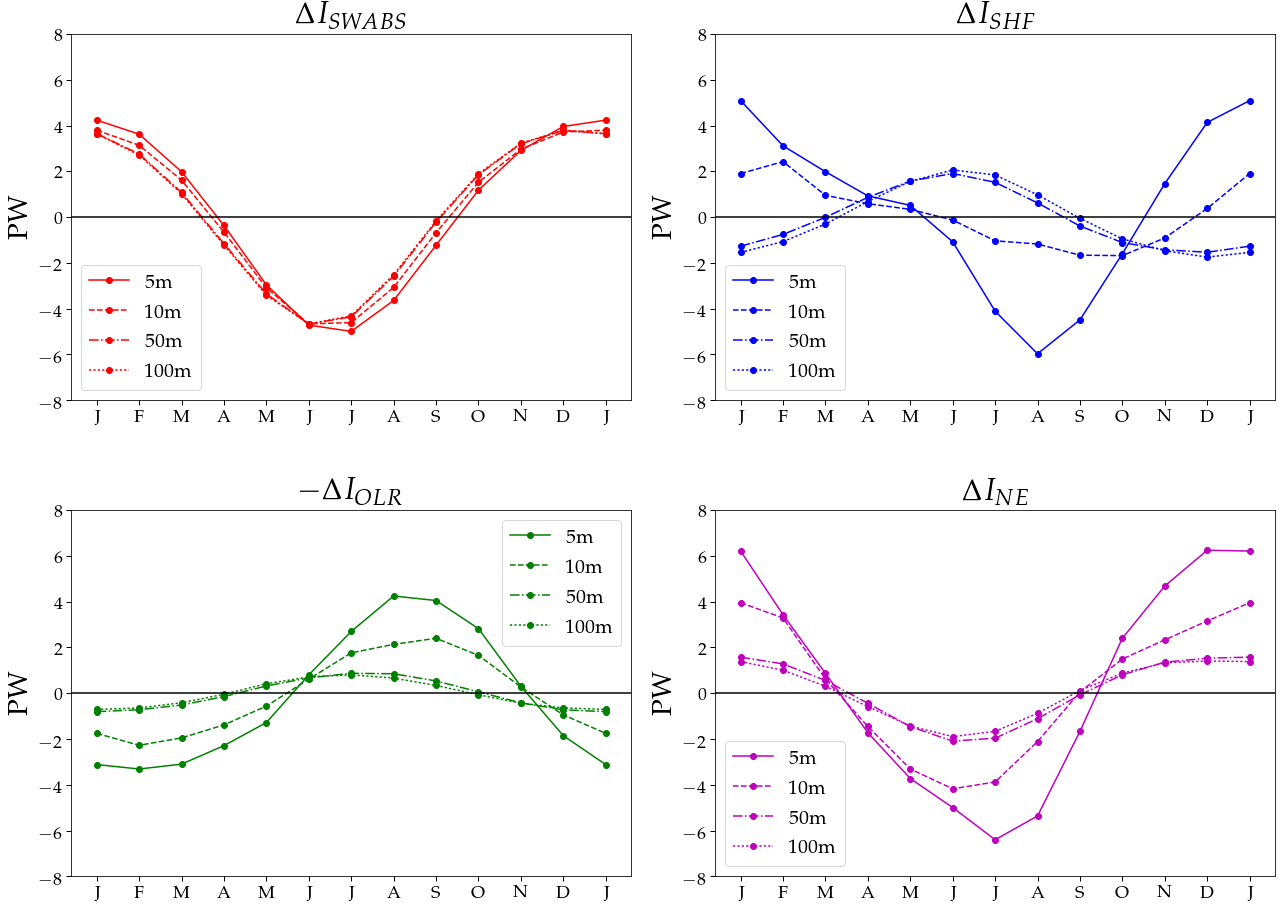

In [76]:
m_to_m=0; l=8
fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB_at40,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(2,I_SHF_at40,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(3,I_OLR_at40,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
compare_plot(4,I_NE_at40,'m',r'$\Delta I_{NE}$',m_to_m,l)

# Decompose SHF to understand what dominates the phase change

In [77]:
# SWABS= +SW_toa - SW_sfc
# SHF  = -(shflx + lhflx + LW_sfc)
# Net_rad2= SWABS + SHF + olr

In [78]:
ISW_toa=np.zeros((4,len(lat[1:-1]),12))
ISW_sfc=np.copy(ISW_toa); Ishflx=np.copy(ISW_toa); Ilhflx=np.copy(ISW_toa);ILW_sfc=np.copy(ISW_toa)

def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    ISW_toa[d,...]=interad(A(SW_toa[d,...]))
    ISW_sfc[d,...]  =interad(A(SW_sfc[d,...]))
    Ishflx[d,...]  =interad(A(shflx[d,...]))
    Ilhflx[d,...] =interad(A(lhflx[d,...]))
    ILW_sfc[d,...] =interad(A(LW_sfc[d,...]))
 

In [80]:
ISW_toa_a, ISW_sfc_a  , Ishflx_a , Ilhflx_a, ILW_sfc_a, latr_a = N_S_avg( ISW_toa, ISW_sfc, Ishflx, Ilhflx, ILW_sfc, lat[1:-1] )

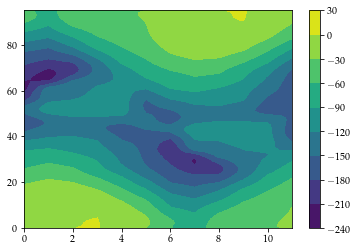

In [87]:
d=0
py.contourf(lhflx[d,...]);py.colorbar()

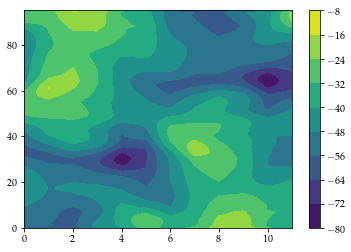

In [88]:
py.contourf(LW_sfc[d,...]);py.colorbar()

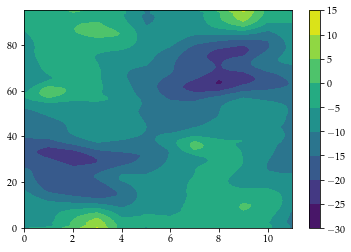

In [89]:
py.contourf(shflx[d,...]);py.colorbar()

In [69]:
# pick the storm track position and identify the index
I_SW_TOA =inerp_at_max(ISW_toa_a,latr_a)
I_SW_SFC =inerp_at_max(ISW_sfc_a,latr_a)
I_SHFLX  =inerp_at_max(Ishflx_a,latr_a)
I_LHFLX  =inerp_at_max(Ilhflx_a,latr_a)
I_LW_SFC =inerp_at_max(ILW_sfc_a,latr_a)

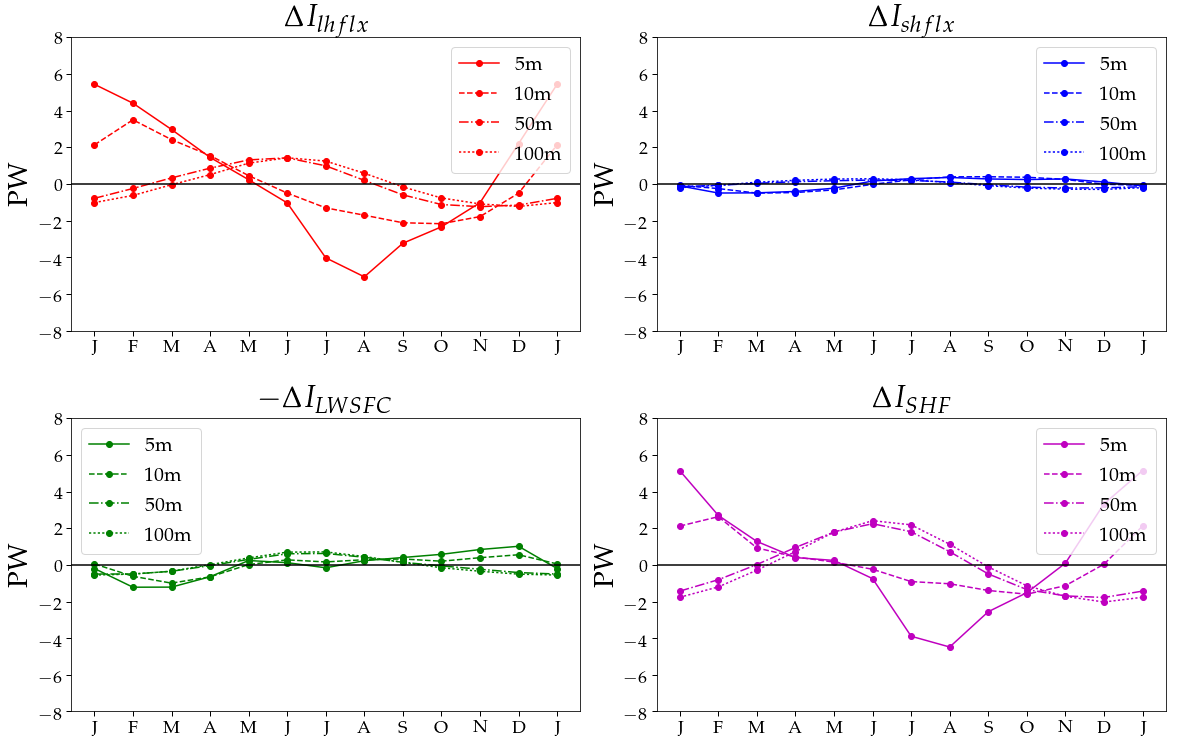

In [70]:
m_to_m=0; l=8
fig=py.figure(figsize=(20, 12))
compare_plot(1,-I_LHFLX,'r',r'$\Delta I_{lhflx}$',m_to_m,l)
compare_plot(2,-I_SHFLX,'b',r'$\Delta I_{shflx}$',m_to_m,l)
compare_plot(3,-I_LW_SFC,'g',r'$ - \Delta I_{LW SFC}$',m_to_m,l)
compare_plot(4,I_SHF,'m',r'$\Delta I_{SHF}$',m_to_m,l)

In [125]:
# SWABS= +SW_toa - SW_sfc
# SHF  = -(shflx + lhflx + LW_sfc)
# Net_rad2= SWABS + SHF + olr

I_sfc_temp =inerp_at_max(sfc_temp_a,lat_a)

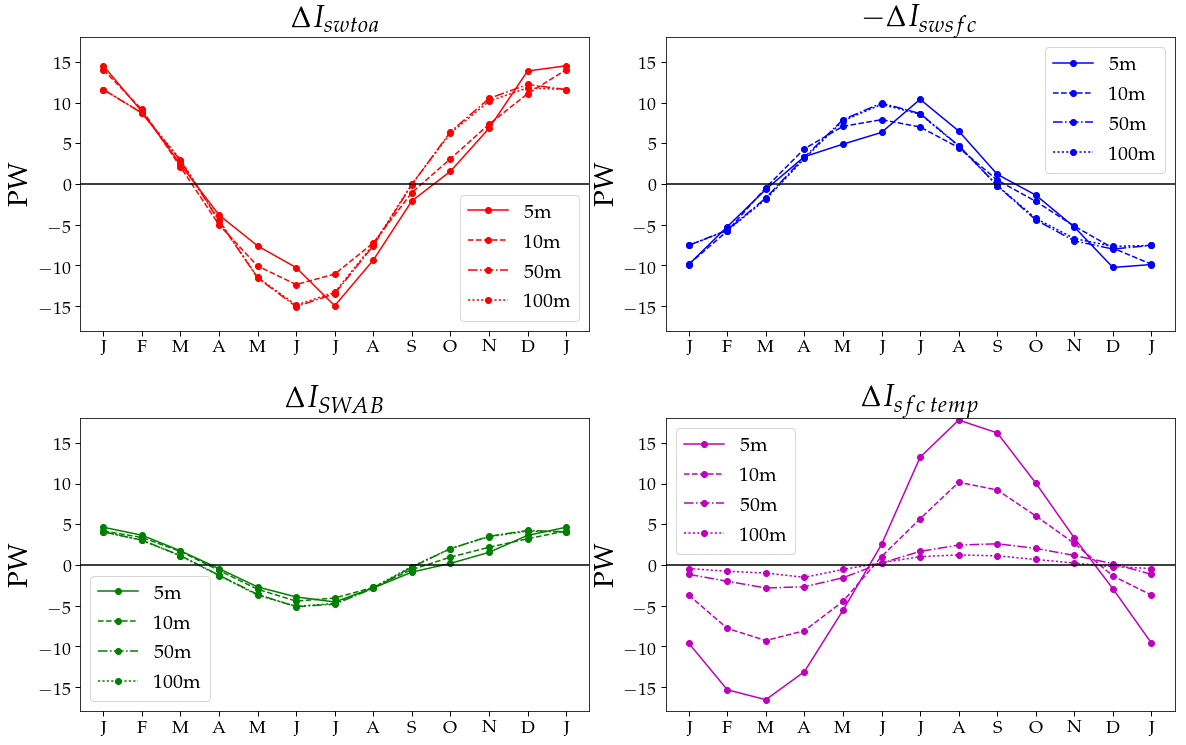

In [127]:
m_to_m=0; l=18
fig=py.figure(figsize=(20, 12))
compare_plot(1,+I_SW_TOA ,'r',r'$\Delta I_{swtoa}$',m_to_m,l)
compare_plot(2,-I_SW_SFC,'b',r'$- \Delta I_{swsfc}$',m_to_m,l)
compare_plot(3,I_SWAB,'g',r'$ \Delta I_{SWAB}$',m_to_m,l)
compare_plot(4,I_sfc_temp,'m',r'$\Delta I_{sfc\:temp}$',m_to_m,l)

# Decompose Net energy in Watts/m^2

In [73]:
# SWABS= +SW_toa - SW_sfc
# SHF  = -(shflx + lhflx + LW_sfc)
# Net_rad2= SWABS + SHF + olr

In [74]:
dhdt=SWABS + SHF + olr-(div_TE+div_SE+div_MM)
# Net_rad2= SWABS + SHF + olr -dhdt

In [75]:
SWABS_a, SHF_a  , NE_a , OLR_a, dhdt_a, lat_a = N_S_avg( SWABS,SHF, Net_rad2 ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)

In [76]:
# pick the storm track position and identify the index
P_SW_TOA =inerp_at_max(SW_toa_a,lat_a)
P_SW_SFC =inerp_at_max(SW_sfc_a,lat_a)
P_SHFLX  =inerp_at_max(shflx_a,lat_a)
P_LHFLX  =inerp_at_max(lhflx_a,lat_a)
P_LW_SFC =inerp_at_max(LW_sfc_a,lat_a)

In [77]:
P_SWABS =inerp_at_max(SWABS_a,lat_a)
P_SHF =inerp_at_max(SHF_a,lat_a)
P_NE  =inerp_at_max(NE_a,lat_a)
P_OLR  =inerp_at_max(OLR_a,lat_a)
P_dhdt =inerp_at_max(dhdt_a,lat_a)

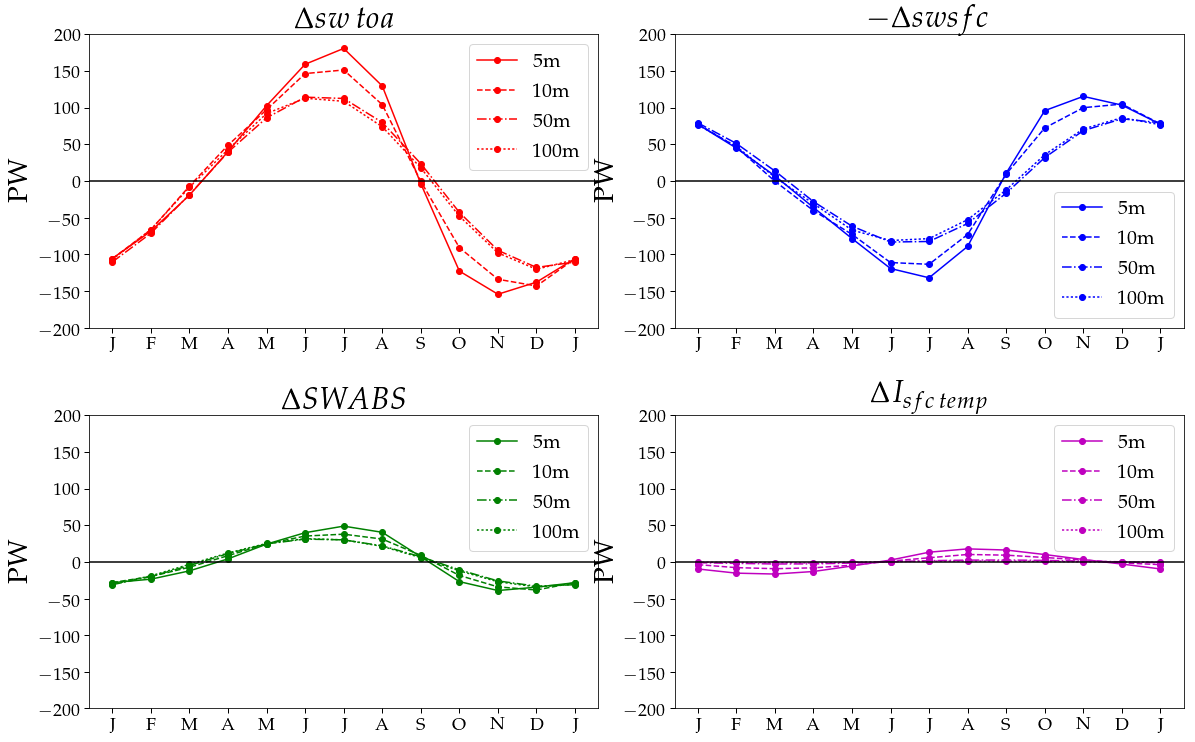

In [128]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot(1,+P_SW_TOA ,'r',r'$\Delta {sw\:toa}$',m_to_m,l)
# compare_plot(1,I_SW_TOA*10,'y',r'$ \Delta I_{SW TOA}$',m_to_m,l)
compare_plot(2,-P_SW_SFC,'b',r'$- \Delta {swsfc}$',m_to_m,l)
# compare_plot(2,-I_SW_SFC*10,'y',r'$ -\Delta I_{SW SFC}$',m_to_m,l)
compare_plot(3,P_SWABS,'g',r'$ \Delta {SWABS}$',m_to_m,l)
compare_plot(4,I_sfc_temp,'m',r'$\Delta I_{sfc\:temp}$',m_to_m,l)
# compare_plot(3,I_SWAB*10,'y',r'$ \Delta I_{SWAB}$',m_to_m,l)
#compare_plot(4,I_SHF,'m',r'$\Delta I_{SHF}$',m_to_m,l)

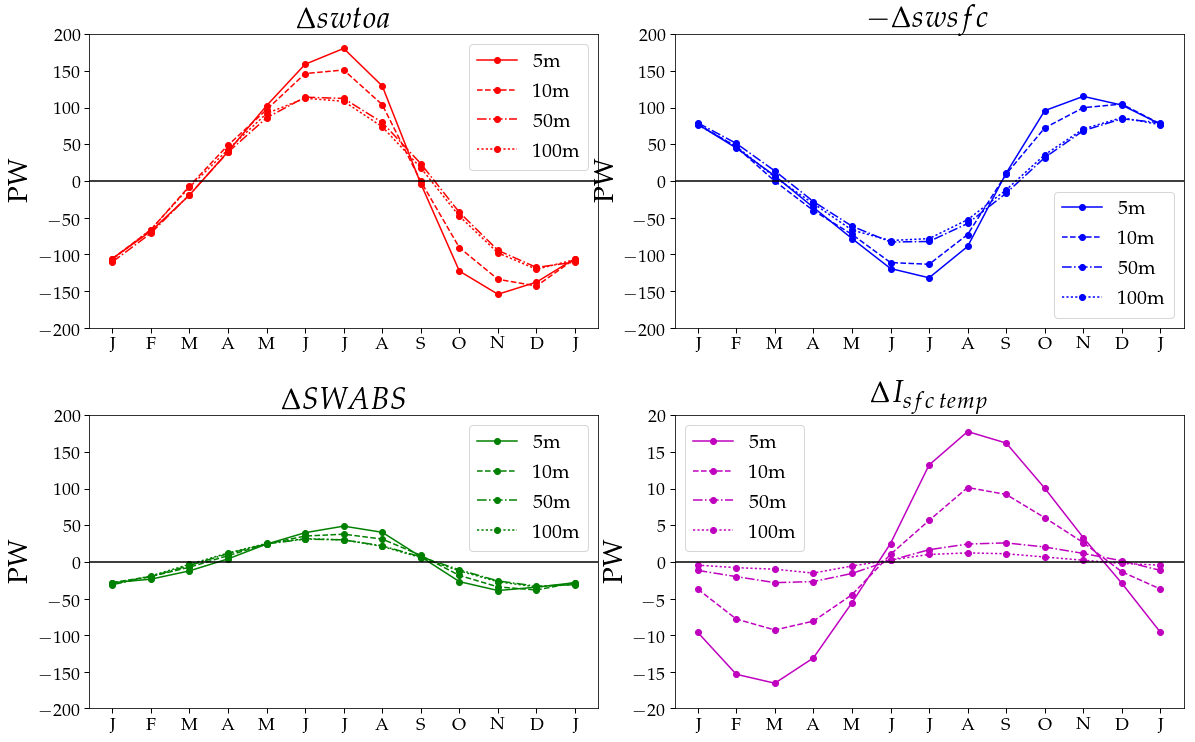

In [129]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot(1,+P_SW_TOA ,'r',r'$\Delta {swtoa}$',m_to_m,l)
compare_plot(2,-P_SW_SFC,'b',r'$- \Delta {swsfc}$',m_to_m,l)
compare_plot(3,P_SWABS,'g',r'$ \Delta {SWABS}$',m_to_m,l)
compare_plot(4,I_sfc_temp,'m',r'$\Delta I_{sfc\:temp}$',m_to_m,l/10)
#compare_plot(4,I_SHF,'m',r'$\Delta I_{SHF}$',m_to_m,l)

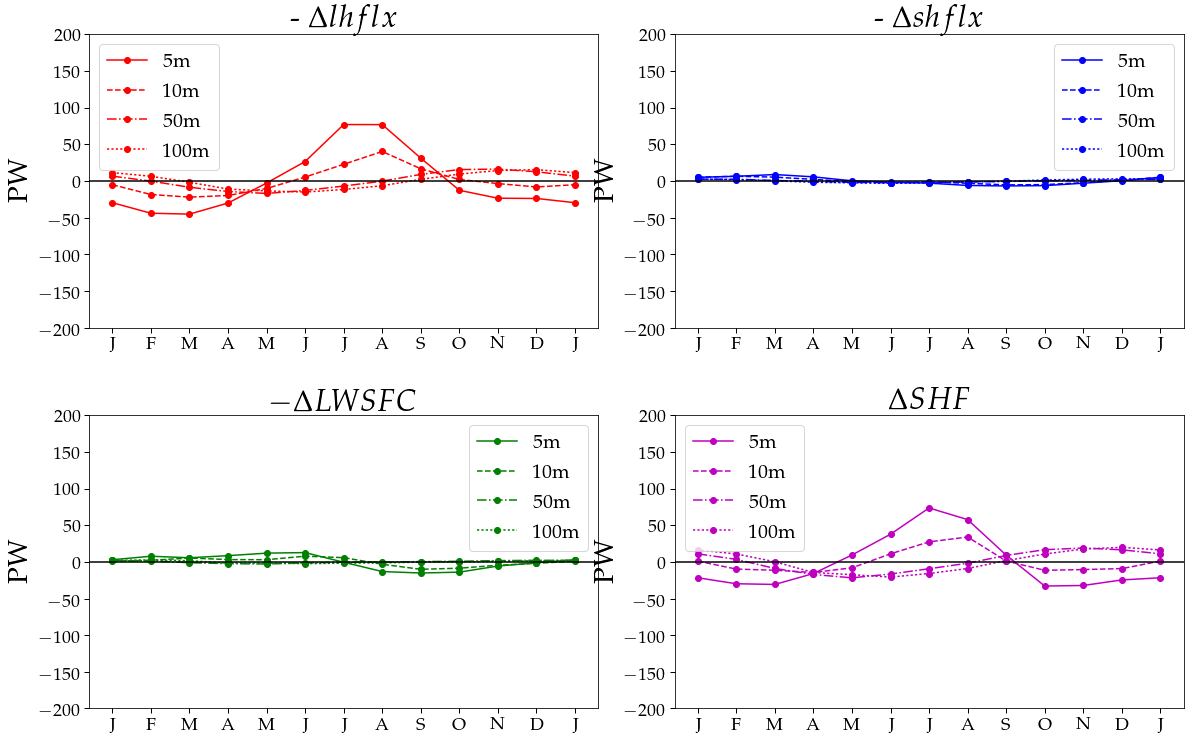

In [80]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot(1,-P_LHFLX,'r',r'- $\Delta {lhflx}$',m_to_m,l)
compare_plot(2,-P_SHFLX,'b',r'- $\Delta {shflx}$',m_to_m,l)
compare_plot(3,-P_LW_SFC,'g',r'$ - \Delta {LW SFC}$',m_to_m,l)
compare_plot(4,P_SHF,'m',r'$\Delta {SHF}$',m_to_m,l)

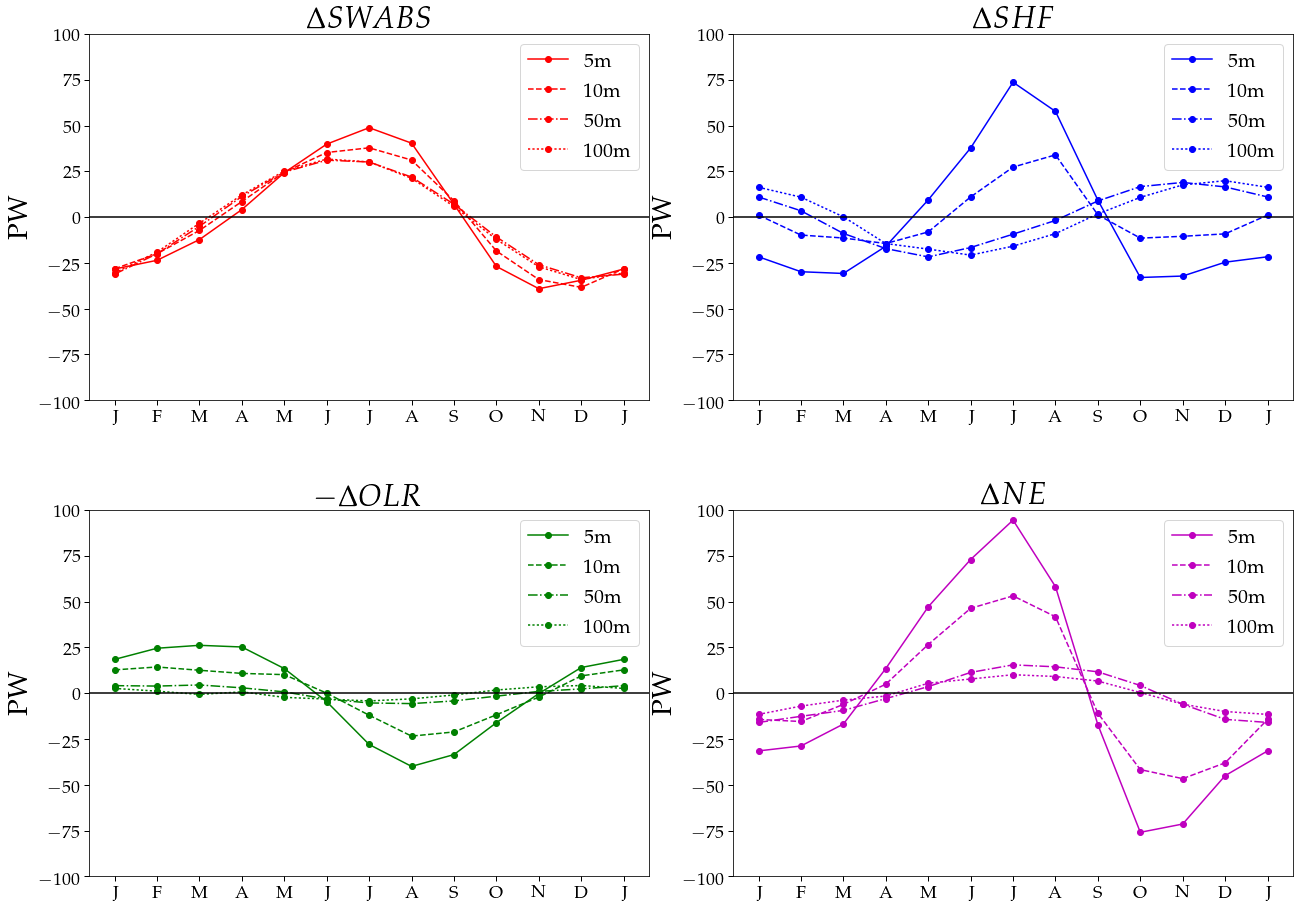

In [81]:
m_to_m=0; l=100
fig=py.figure(figsize=(22, 15))
compare_plot(1,P_SWABS,'r',r'$\Delta {SWABS}$',m_to_m,l)
compare_plot(2,P_SHF,'b',r'$\Delta {SHF}$',m_to_m,l)
compare_plot(3,P_OLR,'g',r'$ - \Delta {OLR}$',m_to_m,l)
compare_plot(4,P_NE,'m',r'$\Delta {NE}$',m_to_m,l)

In [98]:
def inerp_at_mean(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=zero_div_TE[d,:-1].mean()
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [99]:
P_div_TE =inerp_at_mean(div_TE_a,lat_a)
P_div_SE =inerp_at_mean(div_SE_a,lat_a)
P_div_NE =inerp_at_mean(div_NE_a,lat_a)
P_div_MM =inerp_at_mean(div_MM_a,lat_a)

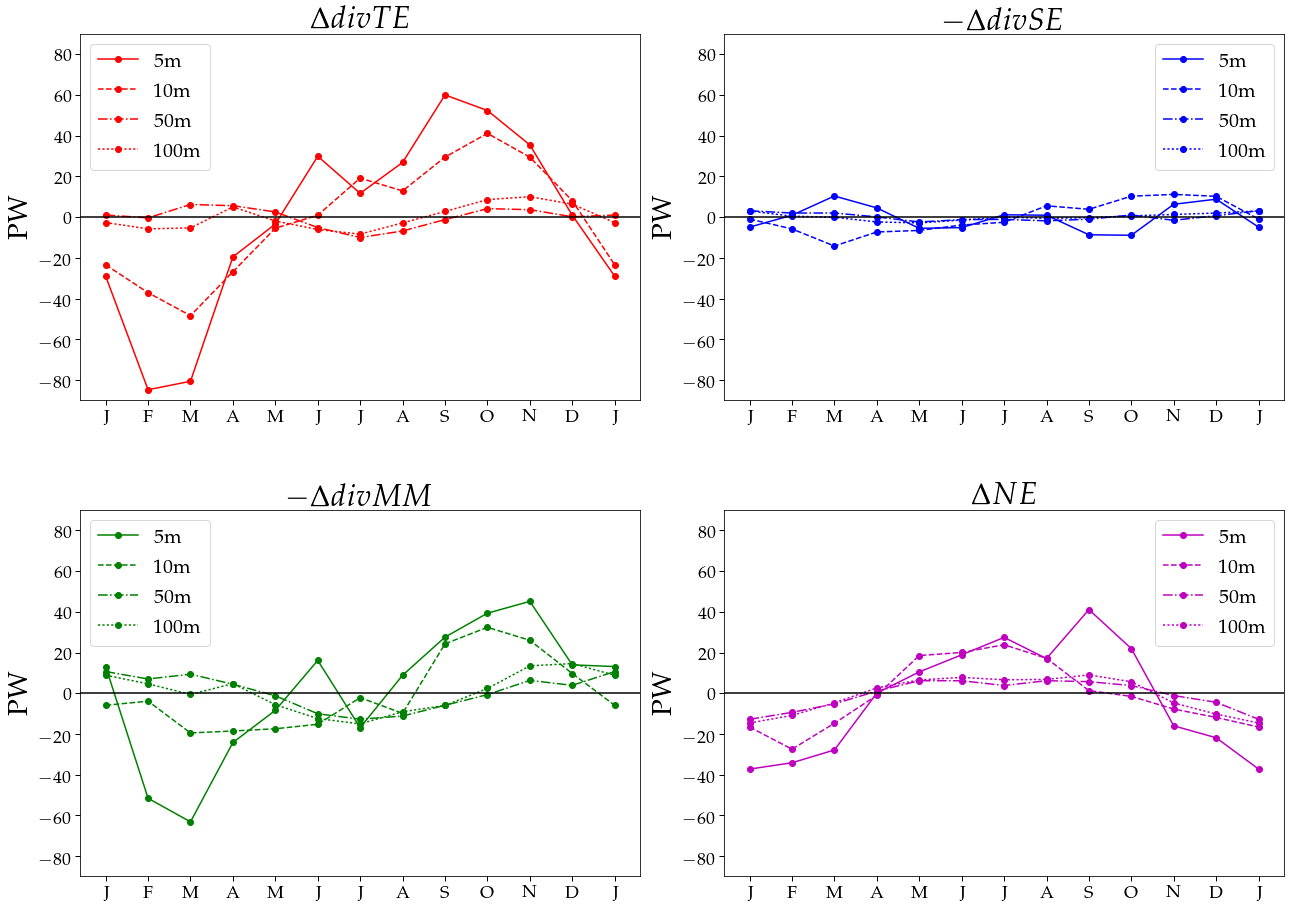

In [105]:
m_to_m=0; l=90
fig=py.figure(figsize=(22, 15))
compare_plot(1,P_div_TE,'r',r'$\Delta {divTE}$',m_to_m,l)
compare_plot(2,-P_div_SE,'b',r'$-\Delta {divSE}$',m_to_m,l)
compare_plot(3,-P_div_MM,'g',r'$-\Delta {divMM}$',m_to_m,l)
compare_plot(4,P_div_NE,'m',r'$\Delta {NE}$',m_to_m,l)

In [84]:
month_to_month=0
threshold_value=+1
SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
#if d==0:
#    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change,47,7), find_zero(SE_change,50,8), find_zero(MM_change,37,7), find_zero(NE_change))else :
#zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,40,5), find_zero(NE_change,35,0))
    
#if ((d==0) & (month_to_month==0)):
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))


2


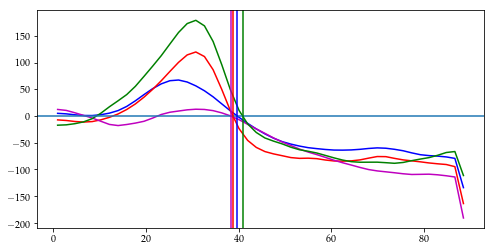

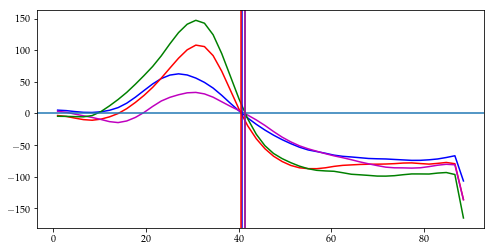

In [85]:
py.figure(1,figsize=(8,4))
m=m+1
d=1
py.plot(lat_a, SE_change[d,:,m],'b-')
py.plot(lat_a,TE_change[d,:,m],'r-')
py.plot(lat_a,NE_change[d,:,m],'m-')
py.plot(lat_a,MM_change[d,:,m],'g-')
py.axhline(0)
py.axvline(zero_div_SE[d,m],color='b')
py.axvline(zero_div_TE[d,m],color='r')
py.axvline(zero_div_MM[d,m],color='g')
py.axvline(zero_div_NE[d,m],color='m')
#py.axvline(base_pos,color='k',linewidth=5)
py.figure(2,figsize=(8,4))
py.plot(lat_a, SE_change[d,:,m+1],'b-')
py.plot(lat_a,TE_change[d,:,m+1],'r-')
py.plot(lat_a,NE_change[d,:,m+1],'m-')
py.plot(lat_a,MM_change[d,:,m+1],'g-')
py.axhline(0)
py.axvline(zero_div_SE[d,m+1],color='b')
py.axvline(zero_div_TE[d,m+1],color='r')
py.axvline(zero_div_MM[d,m+1],color='g')
py.axvline(zero_div_NE[d,m+1],color='m')
#py.axvline(base_pos,color='k',linewidth=5)
print m

# Compare seasonality and intensity

In [86]:
def seasonality(d):
    def M(X):
        l=(X-np.nanmean(X[1:]))/np.nanmax(np.abs(X))
        return l

    fig, ax1 = py.subplots()

    ax1.plot(range(13), M(Intensity_te[d,:]), 'bo-')
    ax1.set_xlabel("Months", color='k',fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel("Intensity (PW)", color='b',fontsize=20)
    ax1.tick_params(labelsize=18)

    ax2 = ax1.twinx()
    ax2.plot(range(13), M(zero_div_TE[d,:]), 'ro-')
    ax2.set_ylabel("Storm track position (deg)", color='r',fontsize=20)
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    py.show()

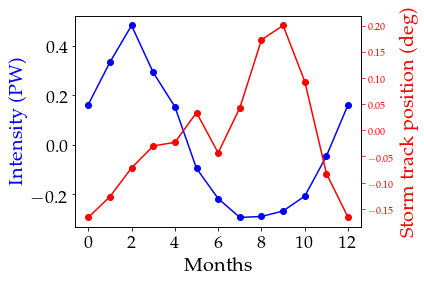

In [87]:
seasonality(0)

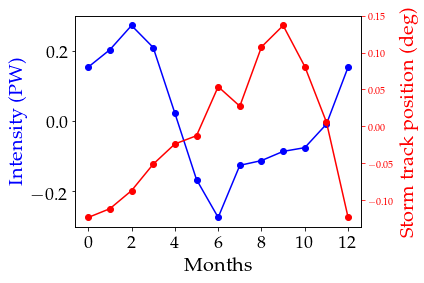

In [75]:
seasonality(1)

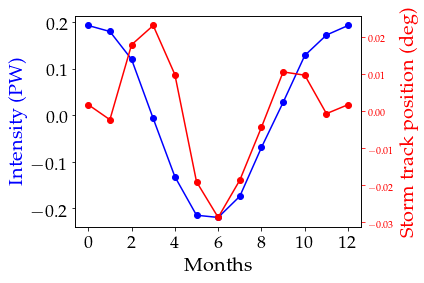

In [88]:
seasonality(2)

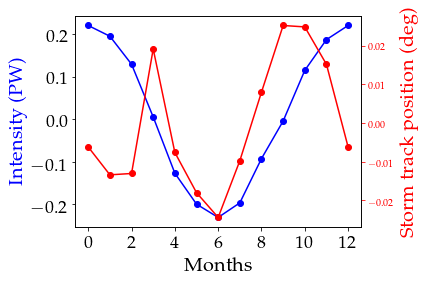

In [89]:
seasonality(3)

In [90]:
def seasonal_value1(X,d):
    delta= np.nanmean(X[d,1:]-X[d,:-1])
    MAX= np.nanmax(np.abs(X[d,:]))
    seas= delta/MAX
    return seas

In [91]:
def seasonal_value2(X,d):
    delta= np.nanmax(np.abs(X[d,:]))-np.nanmin(np.abs(X[d,:]))
    MAX= np.nanmax(np.abs(X[d,:]))
    seas= delta/MAX
    return seas

In [92]:
seas_TE=np.zeros(4); seas_pos=np.copy(seas_TE)
depths=np.array([5,10,50,100])
for d in range(4):
    seas_TE[d]=seasonal_value2(Intensity_te,d)
    seas_pos[d]=seasonal_value2(zero_div_TE,d)

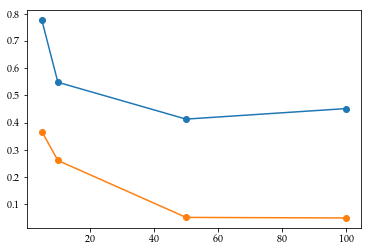

In [93]:
py.plot(depths,seas_TE,'o-')
py.plot(depths,seas_pos,'o-')

In [94]:
print seas_TE
print seas_pos

[ 0.77550026  0.54798445  0.41272416  0.45139388]
[ 0.36691346  0.26088081  0.05183323  0.04969009]


(-13, 13)

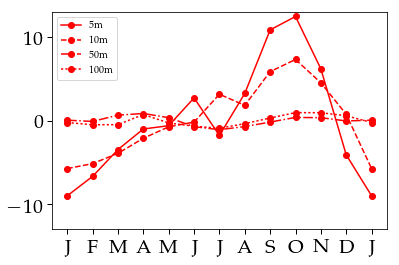

In [95]:
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
m=0
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro-',label='5m')
m=1
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro--',label='10m')
m=2
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro-.',label='50m')
m=3
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro:', label='100m')
py.xticks(range(13),mticks,size=20)
py.tick_params(labelsize=20,size=5,width=1)
py.legend(loc='best')
py.ylim(-13,13)

[[ 36.7104649]]


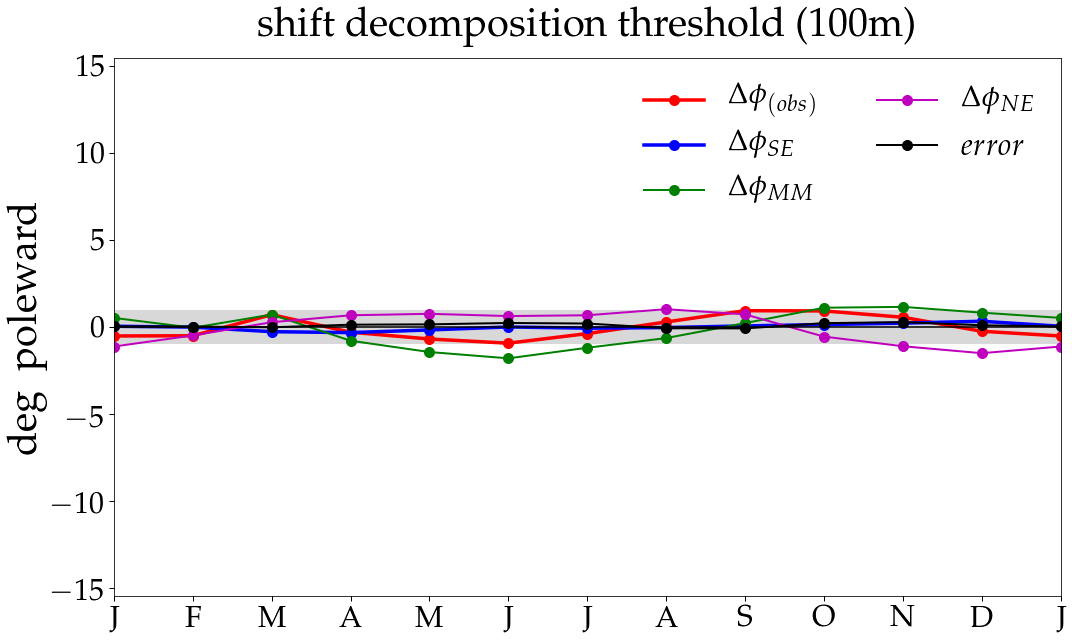

In [65]:
l=15.5
month_to_month=0; threshold_value=+1.0
plot_monthly_shift(3,l,month_to_month,threshold_value)

## Try seasonal shifts averaged over months

In [119]:
def find_zero_seas(div,N=1,mean='no'):   
  if N==1 :
     l_range=((lat>=25) & (lat<=70))            
  if N==-1:
    l_range=((lat>=-70) & (lat<=-25))
  if mean == 'no' :
      zero_loc = np.zeros(np.shape(div)[-1])
      for m in range(0,np.shape(div)[-1]): 
            if N==1 :
                interpolation_function = interp1d(div[l_range,m]      ,lat[l_range]      ,kind='linear')
            if N==-1 :
                interpolation_function = interp1d(div[l_range,m][::-1],lat[l_range][::-1],kind='linear')
            try :
                zero_loc[m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[m]=np.nan
  if mean == 'yes' :                   
        interpolation_function = interp1d(div[l_range],lat[l_range],kind='linear')
        try :
            zero_loc=interpolation_function(0)
        except ValueError as err:
            zero_loc=np.nan                
  return zero_loc

In [120]:
def separate_seasons(X,MO=3):
    season=np.zeros((4,len(lat),12/MO))
    Y=np.append(X[...,-1,None],X[...,:-1],axis=-1)
    for m in range(12):
        if m%MO==0:
            season[:,:,m/MO]=Y[:,:,m:m+MO].mean(axis=-1)
    return season

In [121]:
MO=3
se=np.array(div_SE); te=np.array(div_TE); mm=np.array(div_MM); ne=np.array(div_NE)

SE_seas=separate_seasons(se,MO)
TE_seas=separate_seasons(te,MO)
MM_seas=separate_seasons(mm,MO)
NE_seas=separate_seasons(ne,MO)

In [122]:
def calculate_shift_just_by_adding_individual_flux_divergences(te, se, mm, ne, M):
    
    SE_change=np.zeros((4,len(lat),M+1))
    MM_change=np.zeros((4,len(lat),M+1))
    TE_change=np.zeros((4,len(lat),M+1))
    NE_change=np.zeros((4,len(lat),M+1))
    
    div_se=np.append(se,se[:,:,0,np.newaxis],axis=-1)
    div_mm=np.append(mm,mm[:,:,0,np.newaxis],axis=-1)
    div_te=np.append(te,te[:,:,0,np.newaxis],axis=-1)
    div_ne=np.append(ne,ne[:,:,0,np.newaxis],axis=-1)
    
    for month in range(0,M):

        del_div_SE1=div_se[:,:,month+1]-div_se[:,:,month]
        del_div_MM1=div_mm[:,:,month+1]-div_mm[:,:,month]
        del_div_TE1=div_te[:,:,month+1]-div_te[:,:,month]
        del_div_NE1=div_ne[:,:,month+1]-div_ne[:,:,month]
        
        SE_change[:,:,month+1]=te[:,:,month]-del_div_SE1
        MM_change[:,:,month+1]=te[:,:,month]-del_div_MM1
        TE_change[:,:,month+1]=te[:,:,month]+del_div_TE1
        NE_change[:,:,month+1]=te[:,:,month]+del_div_NE1

    SE_change[:,:,0]=SE_change[:,:,-1]
    TE_change[:,:,0]=TE_change[:,:,-1]
    MM_change[:,:,0]=MM_change[:,:,-1]
    NE_change[:,:,0]=NE_change[:,:,-1]
    return SE_change, MM_change, TE_change, NE_change

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(TE_seas, SE_seas,MM_seas, NE_seas, 12/MO)

In [60]:
def plot_seasonal_shift_method2(N,d,l) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    zero_div_TE=find_zero_seas(TE_change[d,...],N,'no')
    zero_div_SE=find_zero_seas(SE_change[d,...],N,'no')
    zero_div_MM=find_zero_seas(MM_change[d,...],N,'no')
    zero_div_NE=find_zero_seas(NE_change[d,...],N,'no')
    
#     if N==1 :
#         I=Intensity_teN
#     if N==-1 :
#         I=Intensity_teS
        
#     def threshold(I, pos1, pos2, pos3, pos4):
#         I=np.append(I[-1],I)
#         for m in range(13):
#             if (np.abs(I[m])<+1) :
#                 #N[d,m]=np.nan
#                 pos1[m]=np.nan
#                 pos2[m]=np.nan
#                 pos3[m]=np.nan
#                 pos4[m]=np.nan                
# #                 print ok
#         return pos1, pos2, pos3, pos4

#     zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I[d,:], zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE )
        
    final= zero_div_TE.shape[-1]
    m=range(0,final)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))

    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y

    TE_obs         = add_month_to_end(zero_div_TE[1:]-zero_div_TE[:-1])
    SE             = add_month_to_end(zero_div_SE[1:]-zero_div_TE[:-1])
    MM             = add_month_to_end(zero_div_MM[1:]-zero_div_TE[:-1])
    NE             = add_month_to_end(zero_div_NE[1:]-zero_div_TE[:-1])
    TE_calc        = SE+MM+NE
    nonlinear_error= TE_obs-TE_calc
    
    #print TE_obs.shape

    from pandas import DataFrame
    df= DataFrame({ "shiftTE_obs": TE_obs, "shiftSE": SE , "shiftMM": MM, "shiftEI": NE, "err": nonlinear_error})
    print df

    fig=py.plot(N*TE_obs,'r.-',label=r'$\Delta\delta\: (\textrm{obs})$',linewidth=3.5,markersize=20)
    fig=py.plot(N*SE,'b.-',label=r'$\Delta\delta_{\textrm{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(N*MM,'g.-',label=r'$\Delta\delta_{\textrm{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(N*NE,'m.-',label=r'$\Delta\delta_{\textrm{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'$\textrm{error}$',linewidth=2.0,markersize=20)
    #py.legend(fontsize=28,loc='best',ncol=2)
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['DJF - SON','MAM - DJF','JJA - MAM','SON - JJA','DJF - SON']
    py.xlim(0,final-1)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)
    if N==1:
        H="NH"
    else :
        H="SH"        
    title="storm track decomposition"+" "+H+" ("+str(depth)+"m)"
    title1="stormtrack_shift_decomp_"+H+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
#     make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
#     fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

        err   shiftEI   shiftMM   shiftSE  shiftTE_obs
0  0.022682 -1.797644  0.703085  0.154929    -0.916948
1  0.299917  1.238176 -0.924594 -0.191399     0.422100
2  0.038212  0.600923 -1.699689  0.097793    -0.962761
3  0.328691 -0.471589  1.527215  0.073292     1.457609
4  0.022682 -1.797644  0.703085  0.154929    -0.916948


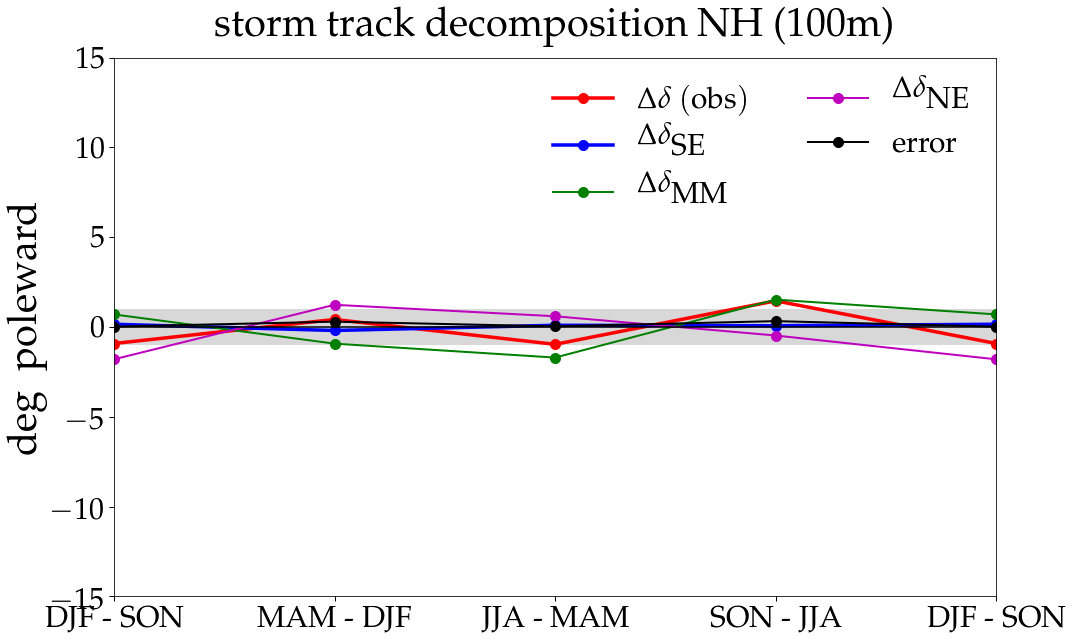

In [127]:
N=1; d=d+1; l=15;
plot_seasonal_shift_method2(N,d,l)